# 1: Import

In [1]:
!pip install -q transformers==4.17

#Download Keras 2 versions of software
!pip install tensorflow==2.15.0 --quiet #15 13
!pip install tf_keras==2.15.0 --quiet
!pip install tensorflow-text==2.15.0 --quiet #15

# Download pytorch for spanBert implementation.
# !pip install torch

#Download Keras 2 versions of software
!pip install tensorflow==2.15.0 --quiet #15 13
!pip install tf_keras==2.15.0 --quiet
!pip install tensorflow-text==2.15.0 --quiet #15

!pip install spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 71.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 49.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 3.2.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.17.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 73.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 106.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.4 MB/s eta 0:

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import spacy
import numpy as np

from spacy.tokenizer import Tokenizer
from spacy.util import compile_infix_regex
import re

nlp = spacy.load("en_core_web_sm")

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import tensorflow as tf
from tensorflow import keras
from transformers import BertTokenizer, TFBertModel, TFBertForSequenceClassification
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.metrics import Precision, Recall
from sklearn.utils.class_weight import compute_class_weight
import random
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix

from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import AdamW

from tensorflow.keras.optimizers import Adam

from transformers import AutoTokenizer, AutoModel

from transformers import TFAutoModel

import torch
from transformers import AutoModel
from transformers import BertTokenizerFast

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import spacy

from collections import defaultdict
from sklearn.utils.class_weight import compute_class_weight

In [4]:
url = 'https://raw.githubusercontent.com/emorynlp/character-mining/refs/heads/master/tsv/friends_transcripts.tsv'
df = pd.read_csv(url, delimiter='\t')

In [5]:
df.head()

,season_id,episode_id,scene_id,utterance_id,speaker,tokens,transcript
0,s01,e01,c01,u001,Monica Geller,"[['There', ""'s"", 'nothing', 'to', 'tell', '!']...",There's nothing to tell! He's just some guy I ...
1,s01,e01,c01,u002,Joey Tribbiani,"[[""C'mon"", ',', 'you', ""'re"", 'going', 'out', ...","C'mon, you're going out with the guy! There's ..."
2,s01,e01,c01,u003,Chandler Bing,"[['All', 'right', 'Joey', ',', 'be', 'nice', '...","All right Joey, be nice. So does he have a hum..."
3,s01,e01,c01,u004,Phoebe Buffay,"[['Wait', ',', 'does', 'he', 'eat', 'chalk', '...","Wait, does he eat chalk?"
4,s01,e01,c01,u005,unknown,[],NaN


# 3: Pre-Processing

## 3.1 Label Processing
Categorize speakers other than the six friends as "OTHER"

In [6]:
def group_minor_characters(df, main_characters):
  """Groups minor characters in a DataFrame as "Other."

  Args:
    df: Pandas DataFrame with a 'speaker' column.
    main_characters: List of speaker names considered main characters.

  Returns:
    DataFrame with the 'speaker' column modified.
  """
  df['speaker'] = df['speaker'].apply(lambda x: x if x in main_characters else "Other")
  return df

main_characters = ["Rachel Green", "Monica Geller", "Phoebe Buffay", "Joey Tribbiani", "Chandler Bing", "Ross Geller"]  # Replace with actual names
df = group_minor_characters(df, main_characters)

# Verify the change
print(df['speaker'].value_counts())

speaker
Other             16061
Rachel Green       9331
Ross Geller        9161
Chandler Bing      8568
Monica Geller      8498
Joey Tribbiani     8215
Phoebe Buffay      7539
Name: count, dtype: int64


## 3.2 Remove NaNs from Transcript

In [7]:
df = df.dropna(subset=['transcript'])

## 3.3 Training/Validation/Test Split

In [8]:
def split_data_by_season(df):
    """Splits data into train, validation, and test sets based on season.

    Args:
        df: Pandas DataFrame with 'season_id', 'transcript', and 'speaker' columns.

    Returns:
        x_train, x_val, x_test, y_train, y_val, y_test: NumPy arrays for features (transcript) and labels (speaker).
    """
    train_df = df[df['season_id'].isin(['s01', 's02', 's03', 's04', 's05', 's06'])]
    val_df = df[df['season_id'] == 's07']
    test_df = df[df['season_id'] == 's08']

    x_train = train_df['transcript'].to_numpy()
    y_train = train_df['speaker'].to_numpy()
    x_val = val_df['transcript'].to_numpy()
    y_val = val_df['speaker'].to_numpy()
    x_test = test_df['transcript'].to_numpy()
    y_test = test_df['speaker'].to_numpy()
    return x_train, x_val, x_test, y_train, y_val, y_test

In [9]:
x_train, x_val, x_test, y_train, y_val, y_test = split_data_by_season(df)

print("X_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (37207,)
y_train shape: (37207,)
X_val shape: (6314,)
y_val shape: (6314,)
X_test shape: (6220,)
y_test shape: (6220,)


## 3.4 Label Encoding

In [10]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)
y_test_encoded = le.transform(y_test)

# 4: Models

## 4.9 BERT + Context (±3, EP) + Syntax + Class Weight
BERT model incorporating three preceding and three following three utterances from the same episode, syntactic features + class weight to adjust for majority class

#### 4.5.0 Prepare context features

##### Balance Classes

In [ ]:
# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_encoded),
    y=y_train_encoded
)

# Create a dictionary mapping class indices to weights
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

##### Prepare data with context

In [ ]:
def split_data_by_season(df):
    """Splits data into train, validation, and test sets based on season.

    Args:
        df: Pandas DataFrame with 'season_id', 'episode_id', 'transcript', and 'speaker' columns.

    Returns:
        train_df, val_df, test_df: DataFrames for training, validation, and test sets.
    """
    train_df = df[df['season_id'].isin(['s01', 's02', 's03', 's04', 's05', 's06'])]
    val_df = df[df['season_id'] == 's07']
    test_df = df[df['season_id'] == 's08']

    return train_df, val_df, test_df


In [ ]:
def prepare_data_with_full_context(df, prior_window_size, following_window_size):
    context_texts = []
    current_utterances = []
    labels = []
    for i in range(len(df)):
        context = []
        current_episode_id = df.iloc[i]['episode_id']
        current_season_id = df.iloc[i]['season_id']

        # Collect preceding utterances with position indicators
        for j in range(prior_window_size, 0, -1):
            idx = i - j
            if idx >= 0:
                prev_row = df.iloc[idx]
                if (prev_row['episode_id'] == current_episode_id and
                    prev_row['season_id'] == current_season_id):
                    utterance = f'[PREV_{j}] ' + prev_row['transcript']
                    context.append(utterance)
                else:
                    context.append(f'[PREV_{j}] [PAD]')
            else:
                context.append(f'[PREV_{j}] [PAD]')

        # Collect following utterances with position indicators
        for j in range(1, following_window_size + 1):
            idx = i + j
            if idx < len(df):
                next_row = df.iloc[idx]
                if (next_row['episode_id'] == current_episode_id and
                    next_row['season_id'] == current_season_id):
                    utterance = f'[NEXT_{j}] ' + next_row['transcript']
                    context.append(utterance)
                else:
                    context.append(f'[NEXT_{j}] [PAD]')
            else:
                context.append(f'[NEXT_{j}] [PAD]')

        # Join context utterances
        context_text = ' '.join(context)
        # Current utterance
        current_utterance = df.iloc[i]['transcript']
        # Append to lists
        context_texts.append(context_text)
        current_utterances.append(current_utterance)
        labels.append(df.iloc[i]['speaker'])
    return context_texts, current_utterances, labels


In [ ]:
train_df, val_df, test_df = split_data_by_season(df)

In [ ]:
prior_window_size = 3
following_window_size = 3
train_context_texts, train_current_utterances, train_labels = prepare_data_with_full_context(train_df, prior_window_size, following_window_size)
val_context_texts, val_current_utterances, val_labels = prepare_data_with_full_context(val_df, prior_window_size, following_window_size)
test_context_texts, test_current_utterances, test_labels = prepare_data_with_full_context(test_df, prior_window_size, following_window_size)

In [ ]:
# Check output.
for i in range(4):
  print(train_context_texts[i])
  print("------------Current Utterance---------")
  print(train_current_utterances[i])
  print("------------Next Example---------")
  print('\n')

[PREV_3] [PAD] [PREV_2] [PAD] [PREV_1] [PAD] [NEXT_1] C'mon, you're going out with the guy! There's gotta be something wrong with him! [NEXT_2] All right Joey, be nice. So does he have a hump? A hump and a hairpiece? [NEXT_3] Wait, does he eat chalk?
------------Current Utterance---------
There's nothing to tell! He's just some guy I work with!
------------Next Example---------


[PREV_3] [PAD] [PREV_2] [PAD] [PREV_1] There's nothing to tell! He's just some guy I work with! [NEXT_1] All right Joey, be nice. So does he have a hump? A hump and a hairpiece? [NEXT_2] Wait, does he eat chalk? [NEXT_3] Just, 'cause, I don't want her to go through what I went through with Carl- oh!
------------Current Utterance---------
C'mon, you're going out with the guy! There's gotta be something wrong with him!
------------Next Example---------


[PREV_3] [PAD] [PREV_2] There's nothing to tell! He's just some guy I work with! [PREV_1] C'mon, you're going out with the guy! There's gotta be something wrong

##### Tokenize context features

In [ ]:
model_checkpoint = 'bert-base-cased'
tokenizer = BertTokenizerFast.from_pretrained(model_checkpoint)
max_length = 500  # close to BERT max

In [ ]:
def tokenize_texts(texts, text_pairs, tokenizer, max_length):
    return tokenizer(
        text=texts,
        text_pair=text_pairs,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='tf',
        return_token_type_ids=True  # Ensure token_type_ids are returned
    )


In [ ]:
# Tokenize training data
train_encodings = tokenize_texts(
    texts=train_context_texts,
    text_pairs=train_current_utterances,
    tokenizer=tokenizer,
    max_length=max_length
)

# Tokenize validation data
val_encodings = tokenize_texts(
    texts=val_context_texts,
    text_pairs=val_current_utterances,
    tokenizer=tokenizer,
    max_length=max_length
)

# Tokenize test data
test_encodings = tokenize_texts(
    texts=test_context_texts,
    text_pairs=test_current_utterances,
    tokenizer=tokenizer,
    max_length=max_length
)


In [ ]:
attention_masks = train_encodings['attention_mask'].numpy()
sequence_lengths = attention_masks.sum(axis=1)

print("Sequence lengths:", sequence_lengths)


Sequence lengths: [115 137 164 ... 108  96  83]


#### 4.5.1 spaCy and Dependency Parsing

In [ ]:
def extract_syntactic_features(texts, nlp):
    all_pos_tags = []
    all_dep_labels = []

    for text in texts:
        doc = nlp(text)
        pos_tags = [token.pos_ for token in doc]
        dep_labels = [token.dep_ for token in doc]
        all_pos_tags.append(pos_tags)
        all_dep_labels.append(dep_labels)

    return all_pos_tags, all_dep_labels

In [ ]:
# Extract syntactic features for context texts
train_context_pos_tags, train_context_dep_labels = extract_syntactic_features(train_context_texts, nlp)
val_context_pos_tags, val_context_dep_labels = extract_syntactic_features(val_context_texts, nlp)
test_context_pos_tags, test_context_dep_labels = extract_syntactic_features(test_context_texts, nlp)

# Extract syntactic features for current utterances
train_current_pos_tags, train_current_dep_labels = extract_syntactic_features(train_current_utterances, nlp)
val_current_pos_tags, val_current_dep_labels = extract_syntactic_features(val_current_utterances, nlp)
test_current_pos_tags, test_current_dep_labels = extract_syntactic_features(test_current_utterances, nlp)


In [ ]:
def tokenize_texts_with_alignment(texts, text_pairs, tokenizer, max_length):
    input_ids = []
    attention_masks = []
    token_type_ids = []
    offset_mappings = []

    for text, text_pair in zip(texts, text_pairs):
        encoding = tokenizer.encode_plus(
            text=text,
            text_pair=text_pair,
            truncation=True,
            padding='max_length',
            max_length=max_length,
            return_tensors='tf',
            return_token_type_ids=True,
            return_offsets_mapping=True  # Get offset mappings
        )
        input_ids.append(encoding['input_ids'])
        attention_masks.append(encoding['attention_mask'])
        token_type_ids.append(encoding['token_type_ids'])
        offset_mappings.append(encoding['offset_mapping'])

    # Stack tensors
    input_ids = tf.concat(input_ids, axis=0)
    attention_masks = tf.concat(attention_masks, axis=0)
    token_type_ids = tf.concat(token_type_ids, axis=0)
    offset_mappings = [mapping.numpy() for mapping in offset_mappings]

    return {
        'input_ids': input_ids,
        'attention_mask': attention_masks,
        'token_type_ids': token_type_ids,
        'offset_mappings': offset_mappings
    }


In [ ]:
def align_spacy_and_bert_tokens(spacy_tokens, bert_offsets):
    aligned_tags = []
    spacy_idx = 0
    spacy_token = spacy_tokens[spacy_idx]

    for bert_offset in bert_offsets:
        start, end = bert_offset
        if start == end:
            # Special tokens (e.g., [CLS], [SEP], padding)
            aligned_tags.append('O')  # Or a special tag
            continue
        bert_token_text = text[start:end]
        # Align spaCy token with BERT token
        if bert_token_text.lower() == spacy_token.text.lower():
            aligned_tags.append(spacy_token.pos_)
            spacy_idx += 1
            if spacy_idx < len(spacy_tokens):
                spacy_token = spacy_tokens[spacy_idx]
        else:
            # Handle subword tokens
            aligned_tags.append(spacy_token.pos_)
    return aligned_tags


In [ ]:
def get_aligned_pos_tags(offset_mapping, spacy_doc):
    pos_tags = []
    spacy_tokens = list(spacy_doc)
    spacy_idx = 0

    for offset in offset_mapping:
        start, end = offset
        if start == end:
            # Special tokens
            pos_tags.append('O')
            continue
        while spacy_idx < len(spacy_tokens) and spacy_tokens[spacy_idx].idx < start:
            spacy_idx += 1
        if spacy_idx < len(spacy_tokens):
            pos_tags.append(spacy_tokens[spacy_idx].pos_)
        else:
            pos_tags.append('O')
    return pos_tags


In [ ]:
def process_and_align_syntactic_features(texts, text_pairs, tokenizer, nlp, max_length):
    encodings = tokenizer(
        texts,
        text_pair=text_pairs,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='tf',
        return_token_type_ids=True,
        return_offsets_mapping=True
    )

    input_ids = encodings['input_ids']
    attention_mask = encodings['attention_mask']
    token_type_ids = encodings['token_type_ids']
    offset_mappings = encodings['offset_mapping'].numpy()

    all_pos_tags = []

    for i in range(len(texts)):
        text = texts[i] if text_pairs is None else texts[i] + ' ' + text_pairs[i]
        doc = nlp(text)
        pos_tags = get_aligned_pos_tags(offset_mappings[i], doc)
        all_pos_tags.append(pos_tags)

    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'token_type_ids': token_type_ids,
        'pos_tags': all_pos_tags
    }


In [ ]:
# Tokenize training data with alignment
train_encodings = tokenize_texts_with_alignment(
    texts=train_context_texts,
    text_pairs=train_current_utterances,
    tokenizer=tokenizer,
    max_length=max_length
)

In [ ]:
# For training data
train_encodings = process_and_align_syntactic_features(
    texts=train_context_texts,
    text_pairs=train_current_utterances,
    tokenizer=tokenizer,
    nlp=nlp,
    max_length=max_length
)


In [ ]:
# Collect all POS tags from the dataset
pos_tag_set = set()
for pos_tags in train_encodings['pos_tags']:
    pos_tag_set.update(pos_tags)

pos_tag2id = {tag: idx for idx, tag in enumerate(sorted(pos_tag_set))}
id2pos_tag = {idx: tag for tag, idx in pos_tag2id.items()}


In [ ]:
def convert_pos_tags_to_ids(pos_tags_list, pos_tag2id):
    pos_tag_ids_list = []
    for pos_tags in pos_tags_list:
        pos_tag_ids = [pos_tag2id.get(tag, pos_tag2id['O']) for tag in pos_tags]
        pos_tag_ids_list.append(pos_tag_ids)
    return pos_tag_ids_list

# For training data
train_pos_tag_ids = convert_pos_tags_to_ids(train_encodings['pos_tags'], pos_tag2id)


In [ ]:
train_pos_tag_ids = tf.constant(train_pos_tag_ids)

In [ ]:
# Process and align syntactic features for validation data
val_encodings = process_and_align_syntactic_features(
    texts=val_context_texts,
    text_pairs=val_current_utterances,
    tokenizer=tokenizer,
    nlp=nlp,
    max_length=max_length
)

# Convert POS tags to IDs for validation data
val_pos_tag_ids = convert_pos_tags_to_ids(val_encodings['pos_tags'], pos_tag2id)
val_pos_tag_ids = tf.constant(val_pos_tag_ids)

# Prepare validation inputs
val_inputs = {
    'input_ids': val_encodings['input_ids'],
    'token_type_ids': val_encodings['token_type_ids'],
    'attention_mask': val_encodings['attention_mask'],
    'pos_tag_ids': val_pos_tag_ids
}


In [ ]:
# Process and align syntactic features for test data
test_encodings = process_and_align_syntactic_features(
    texts=test_context_texts,
    text_pairs=test_current_utterances,
    tokenizer=tokenizer,
    nlp=nlp,
    max_length=max_length
)

# Convert POS tags to IDs for test data
test_pos_tag_ids = convert_pos_tags_to_ids(test_encodings['pos_tags'], pos_tag2id)
test_pos_tag_ids = tf.constant(test_pos_tag_ids)

# Prepare test inputs
test_inputs = {
    'input_ids': test_encodings['input_ids'],
    'token_type_ids': test_encodings['token_type_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'pos_tag_ids': test_pos_tag_ids
}


### 4.3.0 Model Definition

In [ ]:
def build_bert_multiclass_model(num_classes, max_length, pos_tag_vocab_size):
    """Builds a multi-class text classification model using BERT with context windows.

    Args:
        num_classes: The number of output classes (speakers).
        max_length: The maximum sequence length.

    Returns:
        A compiled Keras model.
    """

    # Load pre-trained BERT model
    bert_model = TFBertModel.from_pretrained('bert-base-cased')

    # Enable fine-tuning of BERT weights
    bert_model.trainable = True

    # Input Layers
    input_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="input_ids")
    token_type_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="token_type_ids")
    attention_mask = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="attention_mask")
    pos_tag_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="pos_tag_ids")

    # POS Tag Embedding Layer
    pos_embedding_dim = 32
    pos_embedding = tf.keras.layers.Embedding(
        input_dim=pos_tag_vocab_size,
        output_dim=pos_embedding_dim,
        input_length=max_length,
        name='pos_embedding'
    )(pos_tag_ids)

    # BERT Layer
    bert_outputs = bert_model(
        input_ids=input_ids,
        token_type_ids=token_type_ids,
        attention_mask=attention_mask
    )

    # Combine BERT embeddings with POS embeddings
    sequence_output = bert_outputs.last_hidden_state  # Shape: (batch_size, max_length, hidden_size)
    combined_embeddings = tf.keras.layers.concatenate([sequence_output, pos_embedding], axis=-1)

    # Global Average Pooling
    pooled_output = tf.keras.layers.GlobalAveragePooling1D()(combined_embeddings)

    # Dense Layer
    hidden = tf.keras.layers.Dense(201, activation="relu")(pooled_output)

    # Dropout Layer
    dropout = tf.keras.layers.Dropout(0.3)(hidden)

    # Classification Layer
    classification_output = tf.keras.layers.Dense(
        num_classes, activation="softmax")(dropout)

    # Create the Keras model
    model = tf.keras.Model(
        inputs=[input_ids, token_type_ids, attention_mask, pos_tag_ids],
        outputs=classification_output
    )

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model


### 4.3.1 Callbacks and Random Seeds

### 4.3.2 Model Training

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=1,
    min_lr=1e-6
)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


In [ ]:
# Determine POS tag vocabulary size
pos_tag_vocab_size = len(pos_tag2id)

# Determine the number of speakers
num_speakers = len(np.unique(y_train_encoded))

# Build the model
model = build_bert_multiclass_model(num_speakers, max_length, pos_tag_vocab_size)

# Train the model
history = model.fit(
    x={
        'input_ids': train_encodings['input_ids'],
        'token_type_ids': train_encodings['token_type_ids'],
        'attention_mask': train_encodings['attention_mask'],
        'pos_tag_ids': train_pos_tag_ids
    },
    y=y_train_encoded,
    validation_data=(
        {
            'input_ids': val_encodings['input_ids'],
            'token_type_ids': val_encodings['token_type_ids'],
            'attention_mask': val_encodings['attention_mask'],
            'pos_tag_ids': val_pos_tag_ids
        },
        y_val_encoded
    ),
    epochs=5,
    batch_size=32,
    class_weight=class_weights_dict,  # Apply class weights
    callbacks=[early_stopping, reduce_lr]
)


Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/5


1163/1163 [==============================] - 1000s 828ms/step - loss: 1.7919 - accuracy: 0.2932 - val_loss: 1.6551 - val_accuracy: 0.3676 - lr: 2.0000e-05
Epoch 2/5
1163/1163 [==============================] - 958s 824ms/step - loss: 1.5422 - accuracy: 0.4208 - val_loss: 1.6318 - val_accuracy: 0.3923 - lr: 2.0000e-05
Epoch 3/5
1163/1163 [==============================] - 959s 824ms/step - loss: 1.2759 - accuracy: 0.5314 - val_loss: 1.6414 - val_accuracy: 0.4061 - lr: 2.0000e-05
Epoch 4/5
1163/1163 [==============================] - 958s 824ms/step - loss: 0.9125 - accuracy: 0.6691 - val_loss: 1.8255 - val_accuracy: 0.4062 - lr: 1.0000e-05


### 4.3.3 Model Evaluation

In [ ]:
# Evaluate the model
_, test_accuracy = model.evaluate(
    x={
        'input_ids': test_encodings['input_ids'],
        'token_type_ids': test_encodings['token_type_ids'],
        'attention_mask': test_encodings['attention_mask'],
        'pos_tag_ids': test_pos_tag_ids
    },
    y=y_test_encoded
)
print(f"Test Accuracy: {test_accuracy}")

# Additional evaluation (per-class metrics)
from sklearn.metrics import classification_report

y_pred_probs = model.predict(
    x={
        'input_ids': test_encodings['input_ids'],
        'token_type_ids': test_encodings['token_type_ids'],
        'attention_mask': test_encodings['attention_mask'],
        'pos_tag_ids': test_pos_tag_ids
    }
)
y_pred = np.argmax(y_pred_probs, axis=1)
print(classification_report(y_test_encoded, y_pred, target_names=le.classes_))


195/195 [==============================] - 50s 257ms/step - loss: 1.6441 - accuracy: 0.3875
Test Accuracy: 0.38745981454849243
195/195 [==============================] - 52s 254ms/step
                precision    recall  f1-score   support

 Chandler Bing       0.31      0.33      0.32       677
Joey Tribbiani       0.38      0.61      0.47       909
 Monica Geller       0.32      0.23      0.27       812
         Other       0.47      0.38      0.42       979
 Phoebe Buffay       0.28      0.47      0.35       773
  Rachel Green       0.45      0.36      0.40      1086
   Ross Geller       0.60      0.33      0.42       984

      accuracy                           0.39      6220
     macro avg       0.40      0.39      0.38      6220
  weighted avg       0.41      0.39      0.39      6220



### 4.3.4 Confusion Matrix

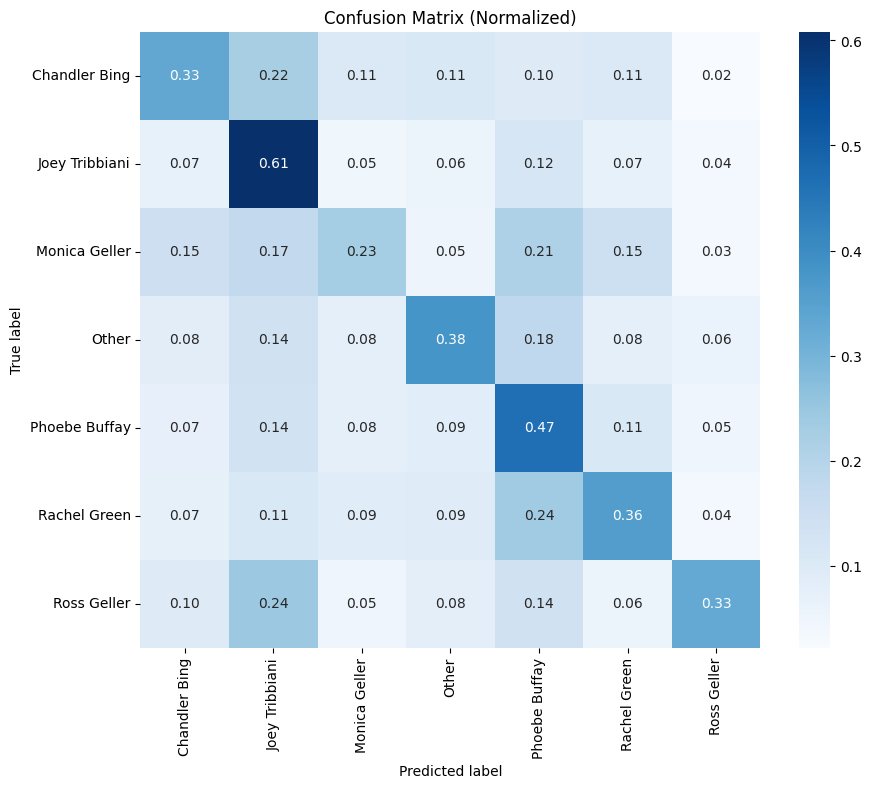

In [ ]:
def create_and_plot_confusion_matrix(y_true, y_pred, target_names):
    """Creates and plots a confusion matrix.

    Args:
        y_true: True labels (NumPy array).
        y_pred: Predicted labels (NumPy array).
        target_names: List of class names (strings).
    """

    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # Normalize for percentages

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm_normalized,
        annot=True,
        fmt=".2f",  # Format numbers to two decimal places
        xticklabels=target_names,
        yticklabels=target_names,
        cmap="Blues",
    )
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title("Confusion Matrix (Normalized)")
    plt.show()


create_and_plot_confusion_matrix(y_test_encoded, y_pred, le.classes_)

In [ ]:
def create_and_plot_confusion_matrix(y_true, y_pred, target_names):
    """Creates, prints, and plots confusion matrices (absolute and normalized).

    Args:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.
        target_names (list): List of class names (strings).
    """

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Compute normalized confusion matrix
    cm_normalized = cm.astype("float") / cm.sum(axis=1, keepdims=True)

    # Create DataFrames for both absolute and normalized confusion matrices
    cm_df = pd.DataFrame(cm, index=target_names, columns=target_names)
    cm_normalized_df = pd.DataFrame(cm_normalized, index=target_names, columns=target_names)

    # Print DataFrames in a table format
    print("Confusion Matrix (Absolute Counts):")
    print(cm_df)
    print("\nConfusion Matrix (Percentages):")
    print(cm_normalized_df)

    # Plot the confusion matrices side by side for visual comparison
    fig, axes = plt.subplots(ncols=2, figsize=(16, 6))

    # Absolute counts heatmap
    sns.heatmap(
        cm_df,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=target_names,
        yticklabels=target_names,
        ax=axes[0]
    )
    axes[0].set_xlabel("Predicted label")
    axes[0].set_ylabel("True label")
    axes[0].set_title("Confusion Matrix (Absolute Counts)")

    # Normalized percentages heatmap
    sns.heatmap(
        cm_normalized_df,
        annot=True,
        fmt=".2f",
        cmap="Blues",
        xticklabels=target_names,
        yticklabels=target_names,
        ax=axes[1]
    )
    axes[1].set_xlabel("Predicted label")
    axes[1].set_ylabel("True label")
    axes[1].set_title("Confusion Matrix (Percentages)")

    plt.tight_layout()
    plt.show()


Confusion Matrix (Absolute Counts):
                Chandler Bing  Joey Tribbiani  Monica Geller  Other  \
Chandler Bing             225             152             72     75   
Joey Tribbiani             62             553             42     52   
Monica Geller             122             142            187     43   
Other                      83             136             76    372   
Phoebe Buffay              55             105             61     67   
Rachel Green               80             119             97    100   
Ross Geller                95             241             49     82   

                Phoebe Buffay  Rachel Green  Ross Geller  
Chandler Bing              66            72           15  
Joey Tribbiani            106            62           32  
Monica Geller             171           119           28  
Other                     178            76           58  
Phoebe Buffay             360            85           40  
Rachel Green              259           3

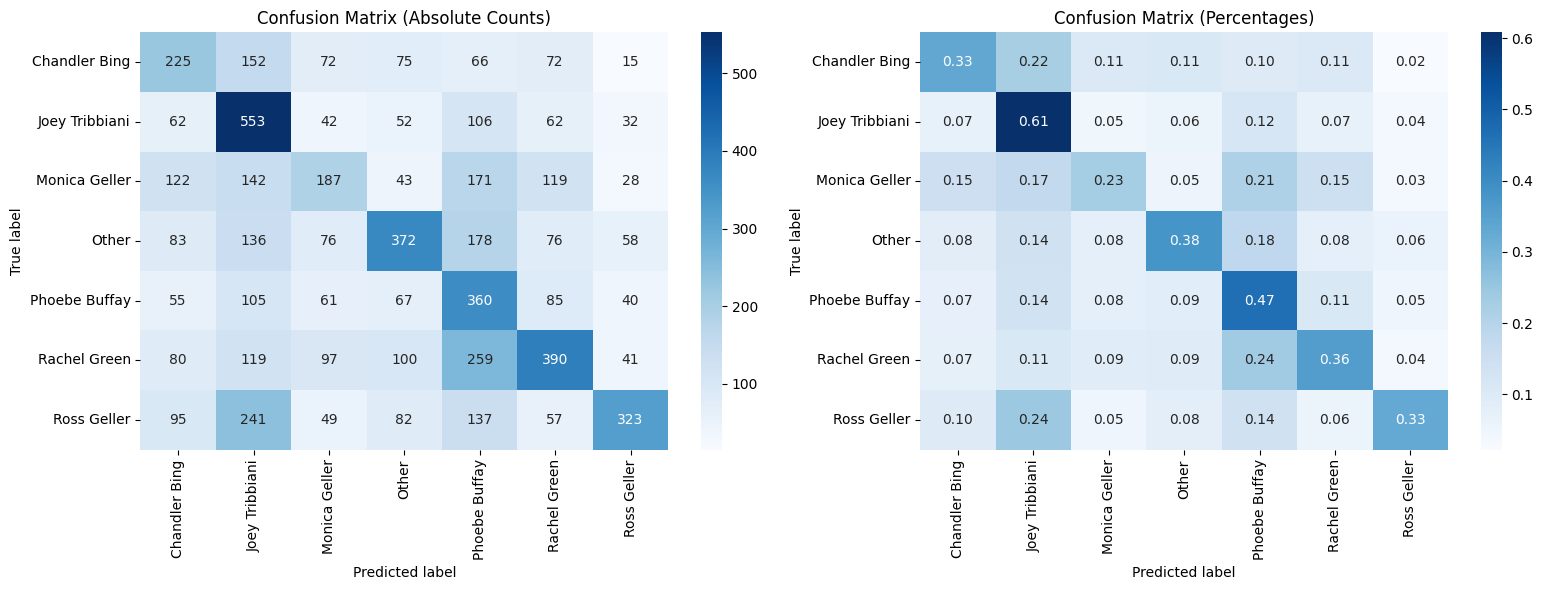

In [ ]:
create_and_plot_confusion_matrix(y_test_encoded, y_pred, le.classes_)

In [ ]:
target_names = le.classes_

In [ ]:
pairs = []
for i, true_cls in enumerate(target_names):
    for j, pred_cls in enumerate(target_names):
        if i != j:
            count = cm[i, j]
            pairs.append((true_cls, pred_cls, count))

# Sort by the count of misclassifications
pairs.sort(key=lambda x: x[2], reverse=True)

# Top pairs are the most commonly confused
print("Top 5 most commonly confused pairs:")
for pair in pairs[:5]:
    print(f"{pair[0]} is often confused as {pair[1]}, count: {pair[2]}")


In [ ]:
cm_normalized = cm.astype("float") / cm.sum(axis=1, keepdims=True)


In [ ]:
pairs_normalized = []
for i, true_cls in enumerate(target_names):
    for j, pred_cls in enumerate(target_names):
        if i != j:
            ratio = cm_normalized[i, j]
            pairs_normalized.append((true_cls, pred_cls, ratio))

pairs_normalized.sort(key=lambda x: x[2], reverse=True)
print("Top 5 most commonly confused pairs (by percentage):")
for pair in pairs_normalized[:5]:
    print(f"{pair[0]} is often confused as {pair[1]}, ratio: {pair[2]:.2f}")


In [ ]:
train_speakers = pd.Series(y_train)
val_speakers = pd.Series(y_val)
test_speakers = pd.Series(y_test)


# Display the distribution (counts) of each speaker in each dataset
print("Train set distribution:")
print(train_speakers.value_counts())

print("\nValidation set distribution:")
print(val_speakers.value_counts())

print("\nTest set distribution:")
print(test_speakers.value_counts())


### 4.3.5 Model Summary

In [ ]:
model.summary()
keras.utils.plot_model(model, show_shapes=True, dpi=90)

### 4.3.6 Error Analysis

In [ ]:
prior_window_size = 3
following_window_size = 3

# True labels from test set
y_true = y_test_encoded

# Map encoded labels back to original labels
true_labels = le.inverse_transform(y_true)
predicted_labels = le.inverse_transform(y_pred)

# Prepare test data with both prior and following utterances
# ensure that 'test_df' matches exactly the order in which test_inputs were created
test_context_texts, test_current_utterances, test_labels = prepare_data_with_full_context(
    test_df,
    prior_window_size=prior_window_size,
    following_window_size=following_window_size
)

# Create a DataFrame with context, current utterance, true and predicted labels
error_df = pd.DataFrame({
    'Context': test_context_texts,
    'Current_Utterance': test_current_utterances,
    'True_Label': true_labels,
    'Predicted_Label': predicted_labels
})

# Identify misclassified examples
misclassified_df = error_df[error_df['True_Label'] != error_df['Predicted_Label']]


print("Misclassified Examples:")
print(misclassified_df.head())


In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
misclassified_df.head(100)

In [ ]:

error_df = pd.DataFrame({
    'season_id': test_df['season_id'].values,
    'episode_id': test_df['episode_id'].values,
    'Context': test_context_texts,
    'Current_Utterance': test_current_utterances,
    'True_Label': true_labels,
    'Predicted_Label': predicted_labels
})

misclassified_df = error_df[error_df['True_Label'] != error_df['Predicted_Label']]


In [ ]:
misclassified_df.head(100)

In [ ]:

# Group by season and episode
grouped = error_df.groupby(['season_id', 'episode_id'])

# Calculate accuracy per group
acc_by_episode = grouped.apply(lambda g: (g['True_Label'] == g['Predicted_Label']).mean())

# Convert to a DataFrame for better readability
acc_by_episode_df = acc_by_episode.reset_index(name='accuracy')

print(acc_by_episode_df)


In [ ]:
# 1. Count utterances per speaker in each dataset
train_counts = train_df['speaker'].value_counts().rename('Training')
val_counts = val_df['speaker'].value_counts().rename('Validation')
test_counts = test_df['speaker'].value_counts().rename('Test')

# 2. Combine the counts into a single DataFrame
utterances_per_speaker = pd.concat([train_counts, val_counts, test_counts], axis=1).fillna(0).astype(int)

speaker_order = ['Other', 'Ross Geller', 'Rachel Green', 'Chandler Bing',
                'Monica Geller', 'Joey Tribbiani', 'Phoebe Buffay']
utterances_per_speaker = utterances_per_speaker.reindex(speaker_order)

# 4. Display the results
print("Number of Utterances per Speaker Across Datasets:\n")
print(utterances_per_speaker)


Number of Utterances per Speaker Across Datasets:

                Training  Validation  Test
speaker                                   
Other               6294         894   979
Ross Geller         5604         822   984
Rachel Green        5470        1093  1086
Chandler Bing       5431         849   677
Monica Geller       5183         907   812
Joey Tribbiani      4774         939   909
Phoebe Buffay       4451         810   773


#### Identify uknown tokens

In [ ]:
# Retrieve the [UNK] token ID
unk_token_id = tokenizer.unk_token_id
print(f"The [UNK] token ID is: {unk_token_id}")


The [UNK] token ID is: 100


In [ ]:
import numpy as np

# Function to count [UNK] tokens
def count_unk_tokens(encodings, unk_id):
    """
    Counts the number of [UNK] tokens in the given encodings.

    Args:
        encodings: Tokenized encodings containing 'input_ids'.
        unk_id: The ID corresponding to the [UNK] token.

    Returns:
        Total count of [UNK] tokens.
    """
    # Convert TensorFlow tensor to NumPy array
    input_ids = encodings['input_ids'].numpy()

    # Count the number of times [UNK] token ID appears
    unk_count = np.sum(input_ids == unk_id)
    return unk_count

# Count [UNK] tokens in training set
train_unk_count = count_unk_tokens(train_encodings, unk_token_id)
print(f"Number of [UNK] tokens in Training Set: {train_unk_count}")

# Count [UNK] tokens in Validation set
val_unk_count = count_unk_tokens(val_encodings, unk_token_id)
print(f"Number of [UNK] tokens in Validation Set: {val_unk_count}")

# Count [UNK] tokens in Test set
test_unk_count = count_unk_tokens(test_encodings, unk_token_id)
print(f"Number of [UNK] tokens in Test Set: {test_unk_count}")


Number of [UNK] tokens in Training Set: 0
Number of [UNK] tokens in Validation Set: 0
Number of [UNK] tokens in Test Set: 0


In [ ]:
# Display all keys in train_encodings
print("Keys in train_encodings:", train_encodings.keys())


Keys in train_encodings: dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'pos_tags'])


In [ ]:
input_ids = train_encodings['input_ids'].numpy()

In [ ]:
np.sum(input_ids == 100)

0

In [ ]:
# Display the first example of each component
for key in train_encodings.keys():
    data = train_encodings[key]
    print(f"\nFirst example of {key}:")
    print(data[0])



First example of input_ids:
tf.Tensor(
[  101   164 11629  2036  2559   168   124   166     0   164 11629  2036
  2559   168   123   166     0   164 11629  2036  2559   168   122   166
     0   164 26546 23206   168   122   166   140   112 19863   117  1128
   112  1231  1280  1149  1114  1103  2564   106  1247   112   188 13224
  1129  1380  2488  1114  1140   106   164 26546 23206   168   123   166
  1398  1268  9300   117  1129  3505   119  1573  1674  1119  1138   170
 21820  1643   136   138 21820  1643  1105   170  1716  9641   136   164
 26546 23206   168   124   166  7911   117  1674  1119  3940 23410   136
   102  1247   112   188  1720  1106  1587   106  1124   112   188  1198
  1199  2564   146  1250  1114   106   102     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     

In [ ]:
# Define the sentence
sentence = "What are you talking about ? We love Schhteve ! Schhteve was schhexy !.. Sorry ."

# Tokenize the sentence
encoding = tokenizer.encode_plus(
    text=sentence,
    add_special_tokens=True,      # Adds [CLS] and [SEP]
    truncation=True,              # Truncate to max_length
    padding='max_length',         # Pad to max_length
    max_length=500,               # Same as your training max_length
    return_attention_mask=True,
    return_token_type_ids=True,
    return_tensors='tf'           # Returns TensorFlow tensors
)

# Display the encoding keys
print("Encoding keys:", encoding.keys())


Encoding keys: dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


In [ ]:
# Retrieve the input_ids tensor and convert to numpy array
input_ids = encoding['input_ids'][0].numpy()

# Convert token IDs to tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids)

# Display the tokens
print("Tokens:")
print(tokens)


Tokens:
['[CLS]', 'What', 'are', 'you', 'talking', 'about', '?', 'We', 'love', 'Sc', '##hh', '##te', '##ve', '!', 'Sc', '##hh', '##te', '##ve', 'was', 's', '##ch', '##he', '##xy', '!', '.', '.', 'Sorry', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',

In [ ]:
# Display token IDs
print("\nToken IDs:")
print(input_ids)



Token IDs:
[  101  1327  1132  1128  2520  1164   136  1284  1567 20452 23830  1566
  2707   106 20452 23830  1566  2707  1108   188  1732  4638 16844   106
   119   119  6502   119   102     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0   

## 4.8 BERT + Context (-3 + 5, EP) + Syntax
BERT model incorporating three preceding and three following **five** utterances from the same episode, syntactic features

#### Prepare context features

##### Prepare data with context

In [ ]:
def split_data_by_season(df):
    """Splits data into train, validation, and test sets based on season.

    Args:
        df: Pandas DataFrame with 'season_id', 'episode_id', 'transcript', and 'speaker' columns.

    Returns:
        train_df, val_df, test_df: DataFrames for training, validation, and test sets.
    """
    train_df = df[df['season_id'].isin(['s01', 's02', 's03', 's04', 's05', 's06'])]
    val_df = df[df['season_id'] == 's07']
    test_df = df[df['season_id'] == 's08']

    return train_df, val_df, test_df


In [ ]:
def prepare_data_with_full_context(df, prior_window_size, following_window_size):
    context_texts = []
    current_utterances = []
    labels = []
    for i in range(len(df)):
        context = []
        current_episode_id = df.iloc[i]['episode_id']
        current_season_id = df.iloc[i]['season_id']

        # Collect preceding utterances with position indicators
        for j in range(prior_window_size, 0, -1):
            idx = i - j
            if idx >= 0:
                prev_row = df.iloc[idx]
                if (prev_row['episode_id'] == current_episode_id and
                    prev_row['season_id'] == current_season_id):
                    utterance = f'[PREV_{j}] ' + prev_row['transcript']
                    context.append(utterance)
                else:
                    context.append(f'[PREV_{j}] [PAD]')
            else:
                context.append(f'[PREV_{j}] [PAD]')

        # Collect following utterances with position indicators
        for j in range(1, following_window_size + 1):
            idx = i + j
            if idx < len(df):
                next_row = df.iloc[idx]
                if (next_row['episode_id'] == current_episode_id and
                    next_row['season_id'] == current_season_id):
                    utterance = f'[NEXT_{j}] ' + next_row['transcript']
                    context.append(utterance)
                else:
                    context.append(f'[NEXT_{j}] [PAD]')
            else:
                context.append(f'[NEXT_{j}] [PAD]')

        # Join context utterances
        context_text = ' '.join(context)
        # Current utterance
        current_utterance = df.iloc[i]['transcript']
        # Append to lists
        context_texts.append(context_text)
        current_utterances.append(current_utterance)
        labels.append(df.iloc[i]['speaker'])
    return context_texts, current_utterances, labels


In [ ]:
train_df, val_df, test_df = split_data_by_season(df)

In [ ]:
prior_window_size = 3
following_window_size = 5
train_context_texts, train_current_utterances, train_labels = prepare_data_with_full_context(train_df, prior_window_size, following_window_size)
val_context_texts, val_current_utterances, val_labels = prepare_data_with_full_context(val_df, prior_window_size, following_window_size)
test_context_texts, test_current_utterances, test_labels = prepare_data_with_full_context(test_df, prior_window_size, following_window_size)

In [ ]:
# Check output.
for i in range(4):
  print(train_context_texts[i])
  print("------------Current Utterance---------")
  print(train_current_utterances[i])
  print("------------Next Example---------")
  print('\n')

[PREV_3] [PAD] [PREV_2] [PAD] [PREV_1] [PAD] [NEXT_1] C'mon, you're going out with the guy! There's gotta be something wrong with him! [NEXT_2] All right Joey, be nice. So does he have a hump? A hump and a hairpiece? [NEXT_3] Wait, does he eat chalk? [NEXT_4] Just, 'cause, I don't want her to go through what I went through with Carl- oh! [NEXT_5] Okay, everybody relax. This is not even a date. It's just two people going out to dinner and- not having sex.
------------Current Utterance---------
There's nothing to tell! He's just some guy I work with!
------------Next Example---------


[PREV_3] [PAD] [PREV_2] [PAD] [PREV_1] There's nothing to tell! He's just some guy I work with! [NEXT_1] All right Joey, be nice. So does he have a hump? A hump and a hairpiece? [NEXT_2] Wait, does he eat chalk? [NEXT_3] Just, 'cause, I don't want her to go through what I went through with Carl- oh! [NEXT_4] Okay, everybody relax. This is not even a date. It's just two people going out to dinner and- not h

##### Tokenize context features

In [ ]:
model_checkpoint = 'bert-base-cased'
tokenizer = BertTokenizerFast.from_pretrained(model_checkpoint)
max_length = 500  # close to BERT max

In [ ]:
def tokenize_texts(texts, text_pairs, tokenizer, max_length):
    return tokenizer(
        text=texts,
        text_pair=text_pairs,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='tf',
        return_token_type_ids=True  # Ensure token_type_ids are returned
    )


In [ ]:
# Tokenize training data
train_encodings = tokenize_texts(
    texts=train_context_texts,
    text_pairs=train_current_utterances,
    tokenizer=tokenizer,
    max_length=max_length
)

# Tokenize validation data
val_encodings = tokenize_texts(
    texts=val_context_texts,
    text_pairs=val_current_utterances,
    tokenizer=tokenizer,
    max_length=max_length
)

# Tokenize test data
test_encodings = tokenize_texts(
    texts=test_context_texts,
    text_pairs=test_current_utterances,
    tokenizer=tokenizer,
    max_length=max_length
)


In [ ]:
attention_masks = train_encodings['attention_mask'].numpy()
sequence_lengths = attention_masks.sum(axis=1)

print("Sequence lengths:", sequence_lengths)


Sequence lengths: [178 184 213 ... 122 110  97]


#### 4.5.1 spaCy and Dependency Parsing

In [ ]:
def extract_syntactic_features(texts, nlp):
    all_pos_tags = []
    all_dep_labels = []

    for text in texts:
        doc = nlp(text)
        pos_tags = [token.pos_ for token in doc]
        dep_labels = [token.dep_ for token in doc]
        all_pos_tags.append(pos_tags)
        all_dep_labels.append(dep_labels)

    return all_pos_tags, all_dep_labels

In [ ]:
# Extract syntactic features for context texts
train_context_pos_tags, train_context_dep_labels = extract_syntactic_features(train_context_texts, nlp)
val_context_pos_tags, val_context_dep_labels = extract_syntactic_features(val_context_texts, nlp)
test_context_pos_tags, test_context_dep_labels = extract_syntactic_features(test_context_texts, nlp)

# Extract syntactic features for current utterances
train_current_pos_tags, train_current_dep_labels = extract_syntactic_features(train_current_utterances, nlp)
val_current_pos_tags, val_current_dep_labels = extract_syntactic_features(val_current_utterances, nlp)
test_current_pos_tags, test_current_dep_labels = extract_syntactic_features(test_current_utterances, nlp)


In [ ]:
def tokenize_texts_with_alignment(texts, text_pairs, tokenizer, max_length):
    input_ids = []
    attention_masks = []
    token_type_ids = []
    offset_mappings = []

    for text, text_pair in zip(texts, text_pairs):
        encoding = tokenizer.encode_plus(
            text=text,
            text_pair=text_pair,
            truncation=True,
            padding='max_length',
            max_length=max_length,
            return_tensors='tf',
            return_token_type_ids=True,
            return_offsets_mapping=True  # Get offset mappings
        )
        input_ids.append(encoding['input_ids'])
        attention_masks.append(encoding['attention_mask'])
        token_type_ids.append(encoding['token_type_ids'])
        offset_mappings.append(encoding['offset_mapping'])

    # Stack tensors
    input_ids = tf.concat(input_ids, axis=0)
    attention_masks = tf.concat(attention_masks, axis=0)
    token_type_ids = tf.concat(token_type_ids, axis=0)
    offset_mappings = [mapping.numpy() for mapping in offset_mappings]

    return {
        'input_ids': input_ids,
        'attention_mask': attention_masks,
        'token_type_ids': token_type_ids,
        'offset_mappings': offset_mappings
    }


In [ ]:
def align_spacy_and_bert_tokens(spacy_tokens, bert_offsets):
    aligned_tags = []
    spacy_idx = 0
    spacy_token = spacy_tokens[spacy_idx]

    for bert_offset in bert_offsets:
        start, end = bert_offset
        if start == end:
            # Special tokens (e.g., [CLS], [SEP], padding)
            aligned_tags.append('O')  # Or a special tag
            continue
        bert_token_text = text[start:end]
        # Align spaCy token with BERT token
        if bert_token_text.lower() == spacy_token.text.lower():
            aligned_tags.append(spacy_token.pos_)
            spacy_idx += 1
            if spacy_idx < len(spacy_tokens):
                spacy_token = spacy_tokens[spacy_idx]
        else:
            # Handle subword tokens
            aligned_tags.append(spacy_token.pos_)
    return aligned_tags


In [ ]:
def get_aligned_pos_tags(offset_mapping, spacy_doc):
    pos_tags = []
    spacy_tokens = list(spacy_doc)
    spacy_idx = 0

    for offset in offset_mapping:
        start, end = offset
        if start == end:
            # Special tokens
            pos_tags.append('O')
            continue
        while spacy_idx < len(spacy_tokens) and spacy_tokens[spacy_idx].idx < start:
            spacy_idx += 1
        if spacy_idx < len(spacy_tokens):
            pos_tags.append(spacy_tokens[spacy_idx].pos_)
        else:
            pos_tags.append('O')
    return pos_tags


In [ ]:
def process_and_align_syntactic_features(texts, text_pairs, tokenizer, nlp, max_length):
    encodings = tokenizer(
        texts,
        text_pair=text_pairs,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='tf',
        return_token_type_ids=True,
        return_offsets_mapping=True
    )

    input_ids = encodings['input_ids']
    attention_mask = encodings['attention_mask']
    token_type_ids = encodings['token_type_ids']
    offset_mappings = encodings['offset_mapping'].numpy()

    all_pos_tags = []

    for i in range(len(texts)):
        text = texts[i] if text_pairs is None else texts[i] + ' ' + text_pairs[i]
        doc = nlp(text)
        pos_tags = get_aligned_pos_tags(offset_mappings[i], doc)
        all_pos_tags.append(pos_tags)

    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'token_type_ids': token_type_ids,
        'pos_tags': all_pos_tags
    }


In [ ]:
# Tokenize training data with alignment
train_encodings = tokenize_texts_with_alignment(
    texts=train_context_texts,
    text_pairs=train_current_utterances,
    tokenizer=tokenizer,
    max_length=max_length
)

In [ ]:
# For training data
train_encodings = process_and_align_syntactic_features(
    texts=train_context_texts,
    text_pairs=train_current_utterances,
    tokenizer=tokenizer,
    nlp=nlp,
    max_length=max_length
)


In [ ]:
# Collect all POS tags from the dataset
pos_tag_set = set()
for pos_tags in train_encodings['pos_tags']:
    pos_tag_set.update(pos_tags)

pos_tag2id = {tag: idx for idx, tag in enumerate(sorted(pos_tag_set))}
id2pos_tag = {idx: tag for tag, idx in pos_tag2id.items()}


In [ ]:
def convert_pos_tags_to_ids(pos_tags_list, pos_tag2id):
    pos_tag_ids_list = []
    for pos_tags in pos_tags_list:
        pos_tag_ids = [pos_tag2id.get(tag, pos_tag2id['O']) for tag in pos_tags]
        pos_tag_ids_list.append(pos_tag_ids)
    return pos_tag_ids_list

# For training data
train_pos_tag_ids = convert_pos_tags_to_ids(train_encodings['pos_tags'], pos_tag2id)


In [ ]:
train_pos_tag_ids = tf.constant(train_pos_tag_ids)

In [ ]:
# Process and align syntactic features for validation data
val_encodings = process_and_align_syntactic_features(
    texts=val_context_texts,
    text_pairs=val_current_utterances,
    tokenizer=tokenizer,
    nlp=nlp,
    max_length=max_length
)

# Convert POS tags to IDs for validation data
val_pos_tag_ids = convert_pos_tags_to_ids(val_encodings['pos_tags'], pos_tag2id)
val_pos_tag_ids = tf.constant(val_pos_tag_ids)

# Prepare validation inputs
val_inputs = {
    'input_ids': val_encodings['input_ids'],
    'token_type_ids': val_encodings['token_type_ids'],
    'attention_mask': val_encodings['attention_mask'],
    'pos_tag_ids': val_pos_tag_ids
}


In [ ]:
# Process and align syntactic features for test data
test_encodings = process_and_align_syntactic_features(
    texts=test_context_texts,
    text_pairs=test_current_utterances,
    tokenizer=tokenizer,
    nlp=nlp,
    max_length=max_length
)

# Convert POS tags to IDs for test data
test_pos_tag_ids = convert_pos_tags_to_ids(test_encodings['pos_tags'], pos_tag2id)
test_pos_tag_ids = tf.constant(test_pos_tag_ids)

# Prepare test inputs
test_inputs = {
    'input_ids': test_encodings['input_ids'],
    'token_type_ids': test_encodings['token_type_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'pos_tag_ids': test_pos_tag_ids
}


### 4.3.0 Model Definition

In [ ]:
def build_bert_multiclass_model(num_classes, max_length, pos_tag_vocab_size):
    """Builds a multi-class text classification model using BERT with context windows.

    Args:
        num_classes: The number of output classes (speakers).
        max_length: The maximum sequence length.

    Returns:
        A compiled Keras model.
    """

    # Load pre-trained BERT model
    bert_model = TFBertModel.from_pretrained('bert-base-cased')

    # Enable fine-tuning of BERT weights
    bert_model.trainable = True

    # Input Layers
    input_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="input_ids")
    token_type_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="token_type_ids")
    attention_mask = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="attention_mask")
    pos_tag_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="pos_tag_ids")

    # POS Tag Embedding Layer
    pos_embedding_dim = 32
    pos_embedding = tf.keras.layers.Embedding(
        input_dim=pos_tag_vocab_size,
        output_dim=pos_embedding_dim,
        input_length=max_length,
        name='pos_embedding'
    )(pos_tag_ids)

    # BERT Layer
    bert_outputs = bert_model(
        input_ids=input_ids,
        token_type_ids=token_type_ids,
        attention_mask=attention_mask
    )

    # Combine BERT embeddings with POS embeddings
    sequence_output = bert_outputs.last_hidden_state  # Shape: (batch_size, max_length, hidden_size)
    combined_embeddings = tf.keras.layers.concatenate([sequence_output, pos_embedding], axis=-1)

    # Global Average Pooling
    pooled_output = tf.keras.layers.GlobalAveragePooling1D()(combined_embeddings)

    # Dense Layer
    hidden = tf.keras.layers.Dense(201, activation="relu")(pooled_output)

    # Dropout Layer
    dropout = tf.keras.layers.Dropout(0.3)(hidden)

    # Classification Layer
    classification_output = tf.keras.layers.Dense(
        num_classes, activation="softmax")(dropout)

    # Create the Keras model
    model = tf.keras.Model(
        inputs=[input_ids, token_type_ids, attention_mask, pos_tag_ids],
        outputs=classification_output
    )

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model


### 4.3.1 Callbacks and Random Seeds

### 4.3.2 Model Training

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=1,
    min_lr=1e-6
)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


In [ ]:
# Determine POS tag vocabulary size
pos_tag_vocab_size = len(pos_tag2id)

# Determine the number of speakers
num_speakers = len(np.unique(y_train_encoded))

# Build the model
model = build_bert_multiclass_model(num_speakers, max_length, pos_tag_vocab_size)

# Train the model
history = model.fit(
    x={
        'input_ids': train_encodings['input_ids'],
        'token_type_ids': train_encodings['token_type_ids'],
        'attention_mask': train_encodings['attention_mask'],
        'pos_tag_ids': train_pos_tag_ids
    },
    y=y_train_encoded,
    validation_data=(
        {
            'input_ids': val_encodings['input_ids'],
            'token_type_ids': val_encodings['token_type_ids'],
            'attention_mask': val_encodings['attention_mask'],
            'pos_tag_ids': val_pos_tag_ids
        },
        y_val_encoded
    ),
    epochs=5,
    batch_size=16,
    callbacks=[early_stopping, reduce_lr]
)


Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/5


2326/2326 [==============================] - 1041s 430ms/step - loss: 1.7831 - accuracy: 0.2998 - val_loss: 1.6484 - val_accuracy: 0.3761 - lr: 2.0000e-05
Epoch 2/5
2326/2326 [==============================] - 997s 429ms/step - loss: 1.5151 - accuracy: 0.4277 - val_loss: 1.6378 - val_accuracy: 0.3925 - lr: 2.0000e-05
Epoch 3/5
2326/2326 [==============================] - 997s 428ms/step - loss: 1.2086 - accuracy: 0.5535 - val_loss: 1.7108 - val_accuracy: 0.3974 - lr: 2.0000e-05
Epoch 4/5
2326/2326 [==============================] - 997s 429ms/step - loss: 0.7985 - accuracy: 0.7122 - val_loss: 1.9207 - val_accuracy: 0.3999 - lr: 1.0000e-05


### 4.3.3 Model Evaluation

In [ ]:
# Evaluate the model
_, test_accuracy = model.evaluate(
    x={
        'input_ids': test_encodings['input_ids'],
        'token_type_ids': test_encodings['token_type_ids'],
        'attention_mask': test_encodings['attention_mask'],
        'pos_tag_ids': test_pos_tag_ids
    },
    y=y_test_encoded
)
print(f"Test Accuracy: {test_accuracy}")

# Additional evaluation (per-class metrics)
from sklearn.metrics import classification_report

y_pred_probs = model.predict(
    x={
        'input_ids': test_encodings['input_ids'],
        'token_type_ids': test_encodings['token_type_ids'],
        'attention_mask': test_encodings['attention_mask'],
        'pos_tag_ids': test_pos_tag_ids
    }
)
y_pred = np.argmax(y_pred_probs, axis=1)
print(classification_report(y_test_encoded, y_pred, target_names=le.classes_))


195/195 [==============================] - 50s 257ms/step - loss: 1.6884 - accuracy: 0.3828
Test Accuracy: 0.3827974200248718
195/195 [==============================] - 52s 253ms/step
                precision    recall  f1-score   support

 Chandler Bing       0.29      0.31      0.30       677
Joey Tribbiani       0.44      0.50      0.47       909
 Monica Geller       0.30      0.33      0.31       812
         Other       0.34      0.67      0.45       979
 Phoebe Buffay       0.36      0.31      0.33       773
  Rachel Green       0.49      0.28      0.35      1086
   Ross Geller       0.65      0.27      0.38       984

      accuracy                           0.38      6220
     macro avg       0.41      0.38      0.37      6220
  weighted avg       0.42      0.38      0.38      6220



### 4.3.4 Confusion Matrix

In [ ]:
def create_and_plot_confusion_matrix(y_true, y_pred, target_names):
    """Creates and plots a confusion matrix.

    Args:
        y_true: True labels (NumPy array).
        y_pred: Predicted labels (NumPy array).
        target_names: List of class names (strings).
    """

    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # Normalize for percentages

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm_normalized,
        annot=True,
        fmt=".2f",  # Format numbers to two decimal places
        xticklabels=target_names,
        yticklabels=target_names,
        cmap="Blues",  # Choose a colormap
    )
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title("Confusion Matrix (Normalized)")
    plt.show()


create_and_plot_confusion_matrix(y_test_encoded, y_pred, le.classes_)

In [ ]:
cm = confusion_matrix(y_true, y_pred)

NameError: name 'y_true' is not defined

In [ ]:
def create_and_plot_confusion_matrix(y_true, y_pred, target_names):
    """Creates, prints, and plots confusion matrices (absolute and normalized).

    Args:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.
        target_names (list): List of class names (strings).
    """

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Compute normalized confusion matrix
    cm_normalized = cm.astype("float") / cm.sum(axis=1, keepdims=True)

    # Create DataFrames for both absolute and normalized confusion matrices
    cm_df = pd.DataFrame(cm, index=target_names, columns=target_names)
    cm_normalized_df = pd.DataFrame(cm_normalized, index=target_names, columns=target_names)

    # Print DataFrames in a table format
    print("Confusion Matrix (Absolute Counts):")
    print(cm_df)
    print("\nConfusion Matrix (Percentages):")
    print(cm_normalized_df)

    # Plot the confusion matrices side by side for visual comparison
    fig, axes = plt.subplots(ncols=2, figsize=(16, 6))

    # Absolute counts heatmap
    sns.heatmap(
        cm_df,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=target_names,
        yticklabels=target_names,
        ax=axes[0]
    )
    axes[0].set_xlabel("Predicted label")
    axes[0].set_ylabel("True label")
    axes[0].set_title("Confusion Matrix (Absolute Counts)")

    # Normalized percentages heatmap
    sns.heatmap(
        cm_normalized_df,
        annot=True,
        fmt=".2f",
        cmap="Blues",
        xticklabels=target_names,
        yticklabels=target_names,
        ax=axes[1]
    )
    axes[1].set_xlabel("Predicted label")
    axes[1].set_ylabel("True label")
    axes[1].set_title("Confusion Matrix (Percentages)")

    plt.tight_layout()
    plt.show()


In [ ]:
create_and_plot_confusion_matrix(y_test_encoded, y_pred, le.classes_)

In [ ]:
target_names = le.classes_

In [ ]:
# cm: confusion matrix (NumPy array), target_names: list of class names
misclassified_counts = []
ratios = []
for i, cls_name in enumerate(target_names):
    row_sum = cm[i, :].sum()
    correct = cm[i, i]
    misclassified = row_sum - correct
    misclassified_counts.append((cls_name, misclassified))
    ratios.append((cls_name, correct / row_sum))

# Sort by misclassified count (descending) to find most and least misclassified
misclassified_counts.sort(key=lambda x: x[1], reverse=True)
most_misclassified_class = misclassified_counts[0][0]
least_misclassified_class = misclassified_counts[-1][0]

print("Most Misclassified Class:", most_misclassified_class)
print("Least Misclassified Class:", least_misclassified_class)


In [ ]:
pairs = []
for i, true_cls in enumerate(target_names):
    for j, pred_cls in enumerate(target_names):
        if i != j:
            count = cm[i, j]
            pairs.append((true_cls, pred_cls, count))

# Sort by the count of misclassifications
pairs.sort(key=lambda x: x[2], reverse=True)

# Top pairs are the most commonly confused
print("Top 5 most commonly confused pairs:")
for pair in pairs[:5]:
    print(f"{pair[0]} is often confused as {pair[1]}, count: {pair[2]}")


In [ ]:
cm_normalized = cm.astype("float") / cm.sum(axis=1, keepdims=True)


In [ ]:
pairs_normalized = []
for i, true_cls in enumerate(target_names):
    for j, pred_cls in enumerate(target_names):
        if i != j:
            ratio = cm_normalized[i, j]
            pairs_normalized.append((true_cls, pred_cls, ratio))

pairs_normalized.sort(key=lambda x: x[2], reverse=True)
print("Top 5 most commonly confused pairs (by percentage):")
for pair in pairs_normalized[:5]:
    print(f"{pair[0]} is often confused as {pair[1]}, ratio: {pair[2]:.2f}")


In [ ]:
train_speakers = pd.Series(y_train)
val_speakers = pd.Series(y_val)
test_speakers = pd.Series(y_test)


# Display the distribution (counts) of each speaker in each dataset
print("Train set distribution:")
print(train_speakers.value_counts())

print("\nValidation set distribution:")
print(val_speakers.value_counts())

print("\nTest set distribution:")
print(test_speakers.value_counts())


### 4.3.5 Model Summary

In [ ]:
model.summary()
keras.utils.plot_model(model, show_shapes=True, dpi=90)

### 4.3.6 Error Analysis

In [ ]:
# Set your context window sizes for prior and following utterances
prior_window_size = 3
following_window_size = 3

# True labels from test set
y_true = y_test_encoded

# Map encoded labels back to original labels
true_labels = le.inverse_transform(y_true)
predicted_labels = le.inverse_transform(y_pred)

# Prepare test data with both prior and following utterances
# ensure that 'test_df' matches exactly the order in which test_inputs were created
test_context_texts, test_current_utterances, test_labels = prepare_data_with_full_context(
    test_df,
    prior_window_size=prior_window_size,
    following_window_size=following_window_size
)

# Create a DataFrame with context, current utterance, true and predicted labels
error_df = pd.DataFrame({
    'Context': test_context_texts,
    'Current_Utterance': test_current_utterances,
    'True_Label': true_labels,
    'Predicted_Label': predicted_labels
})

# Identify misclassified examples
misclassified_df = error_df[error_df['True_Label'] != error_df['Predicted_Label']]

# misclassified_df now contains misclassified instances along with their preceding and following utterances context.
print("Misclassified Examples:")
print(misclassified_df.head())


In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
misclassified_df.head(100)

In [ ]:

error_df = pd.DataFrame({
    'season_id': test_df['season_id'].values,
    'episode_id': test_df['episode_id'].values,
    'Context': test_context_texts,
    'Current_Utterance': test_current_utterances,
    'True_Label': true_labels,
    'Predicted_Label': predicted_labels
})

misclassified_df = error_df[error_df['True_Label'] != error_df['Predicted_Label']]


In [ ]:
misclassified_df.head(100)

In [ ]:
# Group by season and episode
grouped = error_df.groupby(['season_id', 'episode_id'])

# Calculate accuracy per group
acc_by_episode = grouped.apply(lambda g: (g['True_Label'] == g['Predicted_Label']).mean())

# Convert to a DataFrame for better readability
acc_by_episode_df = acc_by_episode.reset_index(name='accuracy')

print(acc_by_episode_df)


## 4.7 BERT + Context (±3, EP) + Syntax **[Best Performing]**
BERT model incorporating three preceding and three following utterances from the same episode, syntactic features

#### Prepare context features

##### Prepare data with context

In [ ]:
def split_data_by_season(df):
    """Splits data into train, validation, and test sets based on season.

    Args:
        df: Pandas DataFrame with 'season_id', 'episode_id', 'transcript', and 'speaker' columns.

    Returns:
        train_df, val_df, test_df: DataFrames for training, validation, and test sets.
    """
    train_df = df[df['season_id'].isin(['s01', 's02', 's03', 's04', 's05', 's06'])]
    val_df = df[df['season_id'] == 's07']
    test_df = df[df['season_id'] == 's08']

    return train_df, val_df, test_df


In [ ]:
def prepare_data_with_full_context(df, prior_window_size, following_window_size):
    context_texts = []
    current_utterances = []
    labels = []
    for i in range(len(df)):
        context = []
        current_episode_id = df.iloc[i]['episode_id']
        current_season_id = df.iloc[i]['season_id']

        # Collect preceding utterances with position indicators
        for j in range(prior_window_size, 0, -1):
            idx = i - j
            if idx >= 0:
                prev_row = df.iloc[idx]
                if (prev_row['episode_id'] == current_episode_id and
                    prev_row['season_id'] == current_season_id):
                    utterance = f'[PREV_{j}] ' + prev_row['transcript']
                    context.append(utterance)
                else:
                    context.append(f'[PREV_{j}] [PAD]')
            else:
                context.append(f'[PREV_{j}] [PAD]')

        # Collect following utterances with position indicators
        for j in range(1, following_window_size + 1):
            idx = i + j
            if idx < len(df):
                next_row = df.iloc[idx]
                if (next_row['episode_id'] == current_episode_id and
                    next_row['season_id'] == current_season_id):
                    utterance = f'[NEXT_{j}] ' + next_row['transcript']
                    context.append(utterance)
                else:
                    context.append(f'[NEXT_{j}] [PAD]')
            else:
                context.append(f'[NEXT_{j}] [PAD]')

        # Join context utterances
        context_text = ' '.join(context)
        # Current utterance
        current_utterance = df.iloc[i]['transcript']
        # Append to lists
        context_texts.append(context_text)
        current_utterances.append(current_utterance)
        labels.append(df.iloc[i]['speaker'])
    return context_texts, current_utterances, labels


In [ ]:
train_df, val_df, test_df = split_data_by_season(df)


In [ ]:
prior_window_size = 3
following_window_size = 3
train_context_texts, train_current_utterances, train_labels = prepare_data_with_full_context(train_df, prior_window_size, following_window_size)
val_context_texts, val_current_utterances, val_labels = prepare_data_with_full_context(val_df, prior_window_size, following_window_size)
test_context_texts, test_current_utterances, test_labels = prepare_data_with_full_context(test_df, prior_window_size, following_window_size)

In [ ]:
# Check output.
for i in range(4):
  print(train_context_texts[i])
  print("------------Current Utterance---------")
  print(train_current_utterances[i])
  print("------------Next Example---------")
  print('\n')

[PREV_3] [PAD] [PREV_2] [PAD] [PREV_1] [PAD] [NEXT_1] C'mon, you're going out with the guy! There's gotta be something wrong with him! [NEXT_2] All right Joey, be nice. So does he have a hump? A hump and a hairpiece? [NEXT_3] Wait, does he eat chalk?
------------Current Utterance---------
There's nothing to tell! He's just some guy I work with!
------------Next Example---------


[PREV_3] [PAD] [PREV_2] [PAD] [PREV_1] There's nothing to tell! He's just some guy I work with! [NEXT_1] All right Joey, be nice. So does he have a hump? A hump and a hairpiece? [NEXT_2] Wait, does he eat chalk? [NEXT_3] Just, 'cause, I don't want her to go through what I went through with Carl- oh!
------------Current Utterance---------
C'mon, you're going out with the guy! There's gotta be something wrong with him!
------------Next Example---------


[PREV_3] [PAD] [PREV_2] There's nothing to tell! He's just some guy I work with! [PREV_1] C'mon, you're going out with the guy! There's gotta be something wrong

##### Tokenize context features

In [ ]:
model_checkpoint = 'bert-base-cased'
tokenizer = BertTokenizerFast.from_pretrained(model_checkpoint)
max_length = 500  # close to BERT max

Downloading:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
def tokenize_texts(texts, text_pairs, tokenizer, max_length):
    return tokenizer(
        text=texts,
        text_pair=text_pairs,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='tf',
        return_token_type_ids=True  # Ensure token_type_ids are returned
    )


In [ ]:
# Tokenize training data
train_encodings = tokenize_texts(
    texts=train_context_texts,
    text_pairs=train_current_utterances,
    tokenizer=tokenizer,
    max_length=max_length
)

# Tokenize validation data
val_encodings = tokenize_texts(
    texts=val_context_texts,
    text_pairs=val_current_utterances,
    tokenizer=tokenizer,
    max_length=max_length
)

# Tokenize test data
test_encodings = tokenize_texts(
    texts=test_context_texts,
    text_pairs=test_current_utterances,
    tokenizer=tokenizer,
    max_length=max_length
)


In [ ]:
attention_masks = train_encodings['attention_mask'].numpy()
sequence_lengths = attention_masks.sum(axis=1)

print("Sequence lengths:", sequence_lengths)


Sequence lengths: [115 137 164 ... 108  96  83]


#### spaCy and Dependency Parsing

In [ ]:
def extract_syntactic_features(texts, nlp):
    all_pos_tags = []
    all_dep_labels = []

    for text in texts:
        doc = nlp(text)
        pos_tags = [token.pos_ for token in doc]
        dep_labels = [token.dep_ for token in doc]
        all_pos_tags.append(pos_tags)
        all_dep_labels.append(dep_labels)

    return all_pos_tags, all_dep_labels

In [ ]:
# Extract syntactic features for context texts
train_context_pos_tags, train_context_dep_labels = extract_syntactic_features(train_context_texts, nlp)
val_context_pos_tags, val_context_dep_labels = extract_syntactic_features(val_context_texts, nlp)
test_context_pos_tags, test_context_dep_labels = extract_syntactic_features(test_context_texts, nlp)

# Extract syntactic features for current utterances
train_current_pos_tags, train_current_dep_labels = extract_syntactic_features(train_current_utterances, nlp)
val_current_pos_tags, val_current_dep_labels = extract_syntactic_features(val_current_utterances, nlp)
test_current_pos_tags, test_current_dep_labels = extract_syntactic_features(test_current_utterances, nlp)


In [ ]:
def tokenize_texts_with_alignment(texts, text_pairs, tokenizer, max_length):
    input_ids = []
    attention_masks = []
    token_type_ids = []
    offset_mappings = []

    for text, text_pair in zip(texts, text_pairs):
        encoding = tokenizer.encode_plus(
            text=text,
            text_pair=text_pair,
            truncation=True,
            padding='max_length',
            max_length=max_length,
            return_tensors='tf',
            return_token_type_ids=True,
            return_offsets_mapping=True  # Get offset mappings
        )
        input_ids.append(encoding['input_ids'])
        attention_masks.append(encoding['attention_mask'])
        token_type_ids.append(encoding['token_type_ids'])
        offset_mappings.append(encoding['offset_mapping'])

    # Stack tensors
    input_ids = tf.concat(input_ids, axis=0)
    attention_masks = tf.concat(attention_masks, axis=0)
    token_type_ids = tf.concat(token_type_ids, axis=0)
    offset_mappings = [mapping.numpy() for mapping in offset_mappings]

    return {
        'input_ids': input_ids,
        'attention_mask': attention_masks,
        'token_type_ids': token_type_ids,
        'offset_mappings': offset_mappings
    }


In [ ]:
def align_spacy_and_bert_tokens(spacy_tokens, bert_offsets):
    aligned_tags = []
    spacy_idx = 0
    spacy_token = spacy_tokens[spacy_idx]

    for bert_offset in bert_offsets:
        start, end = bert_offset
        if start == end:
            # Special tokens (e.g., [CLS], [SEP], padding)
            aligned_tags.append('O')
            continue
        bert_token_text = text[start:end]
        # Align spaCy token with BERT token
        if bert_token_text.lower() == spacy_token.text.lower():
            aligned_tags.append(spacy_token.pos_)
            spacy_idx += 1
            if spacy_idx < len(spacy_tokens):
                spacy_token = spacy_tokens[spacy_idx]
        else:
            # Handle subword tokens
            aligned_tags.append(spacy_token.pos_)
    return aligned_tags


In [ ]:
def get_aligned_pos_tags(offset_mapping, spacy_doc):
    pos_tags = []
    spacy_tokens = list(spacy_doc)
    spacy_idx = 0

    for offset in offset_mapping:
        start, end = offset
        if start == end:
            # Special tokens
            pos_tags.append('O')
            continue
        while spacy_idx < len(spacy_tokens) and spacy_tokens[spacy_idx].idx < start:
            spacy_idx += 1
        if spacy_idx < len(spacy_tokens):
            pos_tags.append(spacy_tokens[spacy_idx].pos_)
        else:
            pos_tags.append('O')
    return pos_tags


In [ ]:
def process_and_align_syntactic_features(texts, text_pairs, tokenizer, nlp, max_length):
    encodings = tokenizer(
        texts,
        text_pair=text_pairs,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='tf',
        return_token_type_ids=True,
        return_offsets_mapping=True
    )

    input_ids = encodings['input_ids']
    attention_mask = encodings['attention_mask']
    token_type_ids = encodings['token_type_ids']
    offset_mappings = encodings['offset_mapping'].numpy()

    all_pos_tags = []

    for i in range(len(texts)):
        text = texts[i] if text_pairs is None else texts[i] + ' ' + text_pairs[i]
        doc = nlp(text)
        pos_tags = get_aligned_pos_tags(offset_mappings[i], doc)
        all_pos_tags.append(pos_tags)

    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'token_type_ids': token_type_ids,
        'pos_tags': all_pos_tags
    }


In [ ]:
# Tokenize training data with alignment
train_encodings = tokenize_texts_with_alignment(
    texts=train_context_texts,
    text_pairs=train_current_utterances,
    tokenizer=tokenizer,
    max_length=max_length
)

In [ ]:
# For training data
train_encodings = process_and_align_syntactic_features(
    texts=train_context_texts,
    text_pairs=train_current_utterances,
    tokenizer=tokenizer,
    nlp=nlp,
    max_length=max_length
)


In [ ]:
# Collect all POS tags from the dataset
pos_tag_set = set()
for pos_tags in train_encodings['pos_tags']:
    pos_tag_set.update(pos_tags)

pos_tag2id = {tag: idx for idx, tag in enumerate(sorted(pos_tag_set))}
id2pos_tag = {idx: tag for tag, idx in pos_tag2id.items()}


In [ ]:
def convert_pos_tags_to_ids(pos_tags_list, pos_tag2id):
    pos_tag_ids_list = []
    for pos_tags in pos_tags_list:
        pos_tag_ids = [pos_tag2id.get(tag, pos_tag2id['O']) for tag in pos_tags]
        pos_tag_ids_list.append(pos_tag_ids)
    return pos_tag_ids_list

# For training data
train_pos_tag_ids = convert_pos_tags_to_ids(train_encodings['pos_tags'], pos_tag2id)


In [ ]:
train_pos_tag_ids = tf.constant(train_pos_tag_ids)

In [ ]:
# Process and align syntactic features for validation data
val_encodings = process_and_align_syntactic_features(
    texts=val_context_texts,
    text_pairs=val_current_utterances,
    tokenizer=tokenizer,
    nlp=nlp,
    max_length=max_length
)

# Convert POS tags to IDs for validation data
val_pos_tag_ids = convert_pos_tags_to_ids(val_encodings['pos_tags'], pos_tag2id)
val_pos_tag_ids = tf.constant(val_pos_tag_ids)

# Prepare validation inputs
val_inputs = {
    'input_ids': val_encodings['input_ids'],
    'token_type_ids': val_encodings['token_type_ids'],
    'attention_mask': val_encodings['attention_mask'],
    'pos_tag_ids': val_pos_tag_ids
}


In [ ]:
# Process and align syntactic features for test data
test_encodings = process_and_align_syntactic_features(
    texts=test_context_texts,
    text_pairs=test_current_utterances,
    tokenizer=tokenizer,
    nlp=nlp,
    max_length=max_length
)

# Convert POS tags to IDs for test data
test_pos_tag_ids = convert_pos_tags_to_ids(test_encodings['pos_tags'], pos_tag2id)
test_pos_tag_ids = tf.constant(test_pos_tag_ids)

# Prepare test inputs
test_inputs = {
    'input_ids': test_encodings['input_ids'],
    'token_type_ids': test_encodings['token_type_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'pos_tag_ids': test_pos_tag_ids
}


### Model Definition

In [ ]:
def build_bert_multiclass_model(num_classes, max_length, pos_tag_vocab_size):
    """Builds a multi-class text classification model using BERT with context windows.

    Args:
        num_classes: The number of output classes (speakers).
        max_length: The maximum sequence length.

    Returns:
        A compiled Keras model.
    """

    # Load pre-trained BERT model
    bert_model = TFBertModel.from_pretrained('bert-base-cased')

    # Enable fine-tuning of BERT weights
    bert_model.trainable = True

    # Input Layers
    input_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="input_ids")
    token_type_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="token_type_ids")
    attention_mask = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="attention_mask")
    pos_tag_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="pos_tag_ids")

    # POS Tag Embedding Layer
    pos_embedding_dim = 32
    pos_embedding = tf.keras.layers.Embedding(
        input_dim=pos_tag_vocab_size,
        output_dim=pos_embedding_dim,
        input_length=max_length,
        name='pos_embedding'
    )(pos_tag_ids)

    # BERT Layer
    bert_outputs = bert_model(
        input_ids=input_ids,
        token_type_ids=token_type_ids,
        attention_mask=attention_mask
    )

    # Combine BERT embeddings with POS embeddings
    sequence_output = bert_outputs.last_hidden_state  # Shape: (batch_size, max_length, hidden_size)
    combined_embeddings = tf.keras.layers.concatenate([sequence_output, pos_embedding], axis=-1)

    # Global Average Pooling
    pooled_output = tf.keras.layers.GlobalAveragePooling1D()(combined_embeddings)

    # Dense Layer
    hidden = tf.keras.layers.Dense(201, activation="relu")(pooled_output)

    # Dropout Layer
    dropout = tf.keras.layers.Dropout(0.3)(hidden)

    # Classification Layer
    classification_output = tf.keras.layers.Dense(
        num_classes, activation="softmax")(dropout)

    # Create the Keras model
    model = tf.keras.Model(
        inputs=[input_ids, token_type_ids, attention_mask, pos_tag_ids],
        outputs=classification_output
    )

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model


### Callbacks and Random Seeds

### Model Training

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=1,
    min_lr=1e-6
)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


In [ ]:
# Determine POS tag vocabulary size
pos_tag_vocab_size = len(pos_tag2id)

# Determine the number of speakers
num_speakers = len(np.unique(y_train_encoded))

# Build the model
model = build_bert_multiclass_model(num_speakers, max_length, pos_tag_vocab_size)

# Train the model
history = model.fit(
    x={
        'input_ids': train_encodings['input_ids'],
        'token_type_ids': train_encodings['token_type_ids'],
        'attention_mask': train_encodings['attention_mask'],
        'pos_tag_ids': train_pos_tag_ids
    },
    y=y_train_encoded,
    validation_data=(
        {
            'input_ids': val_encodings['input_ids'],
            'token_type_ids': val_encodings['token_type_ids'],
            'attention_mask': val_encodings['attention_mask'],
            'pos_tag_ids': val_pos_tag_ids
        },
        y_val_encoded
    ),
    epochs=5,
    batch_size=16,
    callbacks=[early_stopping, reduce_lr]
)


Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/5


2326/2326 [==============================] - 1046s 432ms/step - loss: 1.7809 - accuracy: 0.3002 - val_loss: 1.6425 - val_accuracy: 0.3738 - lr: 2.0000e-05
Epoch 2/5
2326/2326 [==============================] - 1001s 430ms/step - loss: 1.5121 - accuracy: 0.4326 - val_loss: 1.5997 - val_accuracy: 0.4045 - lr: 2.0000e-05
Epoch 3/5
2326/2326 [==============================] - 1000s 430ms/step - loss: 1.2124 - accuracy: 0.5513 - val_loss: 1.7158 - val_accuracy: 0.4083 - lr: 2.0000e-05
Epoch 4/5
2326/2326 [==============================] - 1001s 430ms/step - loss: 0.7928 - accuracy: 0.7154 - val_loss: 1.9283 - val_accuracy: 0.4066 - lr: 1.0000e-05


### Model Evaluation

In [ ]:
# Evaluate the model
_, test_accuracy = model.evaluate(
    x={
        'input_ids': test_encodings['input_ids'],
        'token_type_ids': test_encodings['token_type_ids'],
        'attention_mask': test_encodings['attention_mask'],
        'pos_tag_ids': test_pos_tag_ids
    },
    y=y_test_encoded
)
print(f"Test Accuracy: {test_accuracy}")

# Additional evaluation (per-class metrics)
from sklearn.metrics import classification_report

y_pred_probs = model.predict(
    x={
        'input_ids': test_encodings['input_ids'],
        'token_type_ids': test_encodings['token_type_ids'],
        'attention_mask': test_encodings['attention_mask'],
        'pos_tag_ids': test_pos_tag_ids
    }
)
y_pred = np.argmax(y_pred_probs, axis=1)
print(classification_report(y_test_encoded, y_pred, target_names=le.classes_))


195/195 [==============================] - 50s 258ms/step - loss: 1.6370 - accuracy: 0.3974
Test Accuracy: 0.39742764830589294
195/195 [==============================] - 53s 254ms/step
                precision    recall  f1-score   support

 Chandler Bing       0.27      0.38      0.31       677
Joey Tribbiani       0.49      0.48      0.48       909
 Monica Geller       0.33      0.27      0.30       812
         Other       0.37      0.63      0.47       979
 Phoebe Buffay       0.37      0.34      0.35       773
  Rachel Green       0.44      0.33      0.37      1086
   Ross Geller       0.62      0.34      0.44       984

      accuracy                           0.40      6220
     macro avg       0.41      0.39      0.39      6220
  weighted avg       0.42      0.40      0.40      6220



### Confusion Matrix

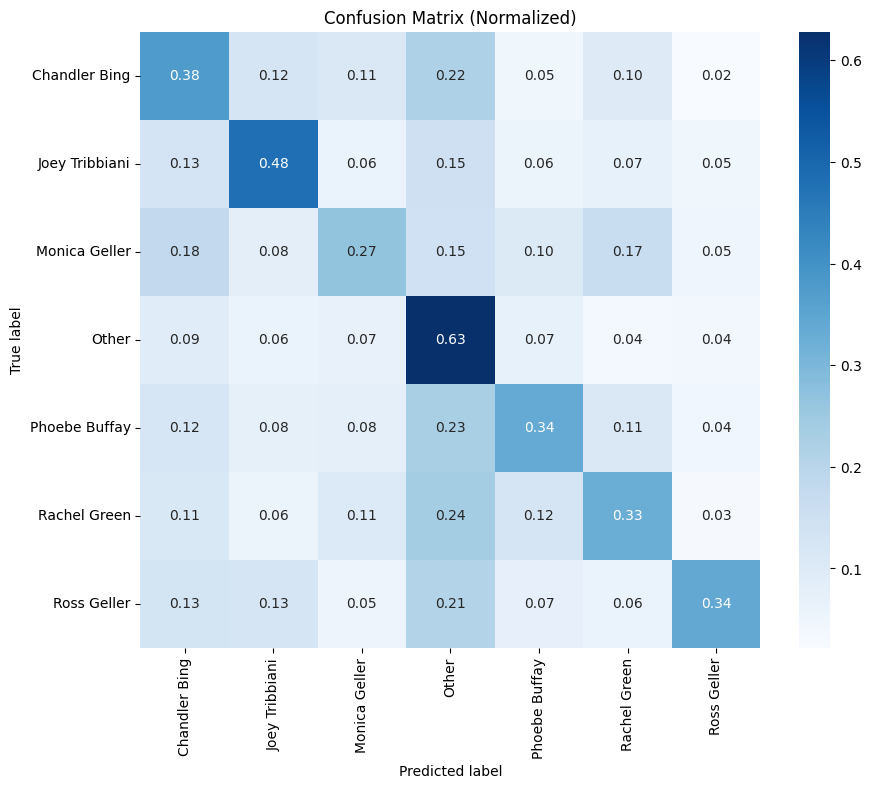

In [ ]:
def create_and_plot_confusion_matrix(y_true, y_pred, target_names):
    """Creates and plots a confusion matrix.

    Args:
        y_true: True labels (NumPy array).
        y_pred: Predicted labels (NumPy array).
        target_names: List of class names (strings).
    """

    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # Normalize for percentages

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm_normalized,
        annot=True,
        fmt=".2f",  # Format numbers to two decimal places
        xticklabels=target_names,
        yticklabels=target_names,
        cmap="Blues",
    )
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title("Confusion Matrix (Normalized)")
    plt.show()


create_and_plot_confusion_matrix(y_test_encoded, y_pred, le.classes_)

In [ ]:
cm = confusion_matrix(y_true, y_pred)

In [ ]:
cm

array([[255,  84,  75, 149,  32,  67,  15],
       [117, 437,  58, 136,  54,  65,  42],
       [148,  68, 217, 119,  84, 134,  42],
       [ 89,  60,  68, 615,  70,  37,  40],
       [ 95,  59,  61, 178, 260,  86,  34],
       [123,  65, 115, 260, 135, 354,  34],
       [131, 124,  54, 207,  72,  62, 334]])

In [ ]:
def create_and_plot_confusion_matrix(y_true, y_pred, target_names):
    """Creates, prints, and plots confusion matrices (absolute and normalized).

    Args:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.
        target_names (list): List of class names (strings).
    """

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Compute normalized confusion matrix
    cm_normalized = cm.astype("float") / cm.sum(axis=1, keepdims=True)

    # Create DataFrames for both absolute and normalized confusion matrices
    cm_df = pd.DataFrame(cm, index=target_names, columns=target_names)
    cm_normalized_df = pd.DataFrame(cm_normalized, index=target_names, columns=target_names)

    # Print DataFrames in a table format
    print("Confusion Matrix (Absolute Counts):")
    print(cm_df)
    print("\nConfusion Matrix (Percentages):")
    print(cm_normalized_df)

    # Plot the confusion matrices side by side for visual comparison
    fig, axes = plt.subplots(ncols=2, figsize=(16, 6))

    # Absolute counts heatmap
    sns.heatmap(
        cm_df,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=target_names,
        yticklabels=target_names,
        ax=axes[0]
    )
    axes[0].set_xlabel("Predicted label")
    axes[0].set_ylabel("True label")
    axes[0].set_title("Confusion Matrix (Absolute Counts)")

    # Normalized percentages heatmap
    sns.heatmap(
        cm_normalized_df,
        annot=True,
        fmt=".2f",
        cmap="Blues",
        xticklabels=target_names,
        yticklabels=target_names,
        ax=axes[1]
    )
    axes[1].set_xlabel("Predicted label")
    axes[1].set_ylabel("True label")
    axes[1].set_title("Confusion Matrix (Percentages)")

    plt.tight_layout()
    plt.show()


Confusion Matrix (Absolute Counts):
                Chandler Bing  Joey Tribbiani  Monica Geller  Other  \
Chandler Bing             255              84             75    149   
Joey Tribbiani            117             437             58    136   
Monica Geller             148              68            217    119   
Other                      89              60             68    615   
Phoebe Buffay              95              59             61    178   
Rachel Green              123              65            115    260   
Ross Geller               131             124             54    207   

                Phoebe Buffay  Rachel Green  Ross Geller  
Chandler Bing              32            67           15  
Joey Tribbiani             54            65           42  
Monica Geller              84           134           42  
Other                      70            37           40  
Phoebe Buffay             260            86           34  
Rachel Green              135           3

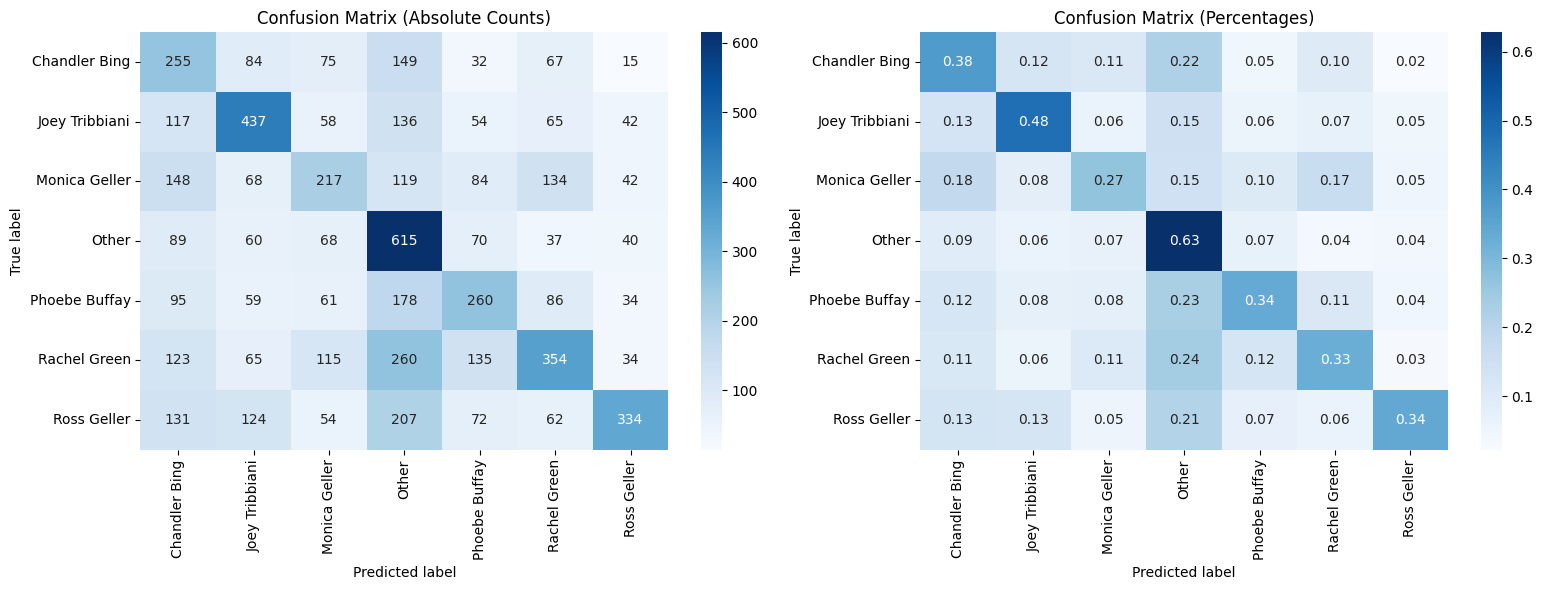

In [ ]:
create_and_plot_confusion_matrix(y_test_encoded, y_pred, le.classes_)

In [ ]:
target_names = le.classes_

In [ ]:
# cm: confusion matrix (NumPy array), target_names: list of class names
misclassified_counts = []
ratios = []
for i, cls_name in enumerate(target_names):
    row_sum = cm[i, :].sum()
    correct = cm[i, i]
    misclassified = row_sum - correct
    misclassified_counts.append((cls_name, misclassified))
    ratios.append((cls_name, correct / row_sum))

# Sort by misclassified count (descending) to find most and least misclassified
misclassified_counts.sort(key=lambda x: x[1], reverse=True)
most_misclassified_class = misclassified_counts[0][0]
least_misclassified_class = misclassified_counts[-1][0]

print("Most Misclassified Class:", most_misclassified_class)
print("Least Misclassified Class:", least_misclassified_class)


Most Misclassified Class: Rachel Green
Least Misclassified Class: Other


In [ ]:
pairs = []
for i, true_cls in enumerate(target_names):
    for j, pred_cls in enumerate(target_names):
        if i != j:
            count = cm[i, j]
            pairs.append((true_cls, pred_cls, count))

# Sort by the count of misclassifications
pairs.sort(key=lambda x: x[2], reverse=True)

# Top pairs are the most commonly confused
print("Top 5 most commonly confused pairs:")
for pair in pairs[:5]:
    print(f"{pair[0]} is often confused as {pair[1]}, count: {pair[2]}")


Top 5 most commonly confused pairs:
Rachel Green is often confused as Other, count: 260
Ross Geller is often confused as Other, count: 207
Phoebe Buffay is often confused as Other, count: 178
Chandler Bing is often confused as Other, count: 149
Monica Geller is often confused as Chandler Bing, count: 148


In [ ]:
cm_normalized = cm.astype("float") / cm.sum(axis=1, keepdims=True)


In [ ]:
pairs_normalized = []
for i, true_cls in enumerate(target_names):
    for j, pred_cls in enumerate(target_names):
        if i != j:
            ratio = cm_normalized[i, j]
            pairs_normalized.append((true_cls, pred_cls, ratio))

pairs_normalized.sort(key=lambda x: x[2], reverse=True)
print("Top 5 most commonly confused pairs (by percentage):")
for pair in pairs_normalized[:5]:
    print(f"{pair[0]} is often confused as {pair[1]}, ratio: {pair[2]:.2f}")


Top 5 most commonly confused pairs (by percentage):
Rachel Green is often confused as Other, ratio: 0.24
Phoebe Buffay is often confused as Other, ratio: 0.23
Chandler Bing is often confused as Other, ratio: 0.22
Ross Geller is often confused as Other, ratio: 0.21
Monica Geller is often confused as Chandler Bing, ratio: 0.18


In [ ]:
train_speakers = pd.Series(y_train)
val_speakers = pd.Series(y_val)
test_speakers = pd.Series(y_test)


# Display the distribution (counts) of each speaker in each dataset
print("Train set distribution:")
print(train_speakers.value_counts())

print("\nValidation set distribution:")
print(val_speakers.value_counts())

print("\nTest set distribution:")
print(test_speakers.value_counts())


Train set distribution:
Other             6294
Ross Geller       5604
Rachel Green      5470
Chandler Bing     5431
Monica Geller     5183
Joey Tribbiani    4774
Phoebe Buffay     4451
Name: count, dtype: int64

Validation set distribution:
Rachel Green      1093
Joey Tribbiani     939
Monica Geller      907
Other              894
Chandler Bing      849
Ross Geller        822
Phoebe Buffay      810
Name: count, dtype: int64

Test set distribution:
Rachel Green      1086
Ross Geller        984
Other              979
Joey Tribbiani     909
Monica Geller      812
Phoebe Buffay      773
Chandler Bing      677
Name: count, dtype: int64


### Model Summary

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 500)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 500)]                0         []                            
 )                                                                                                
                                                                                                  
 token_type_ids (InputLayer  [(None, 500)]                0         []                            
 )                                                                                                
                                                                                              

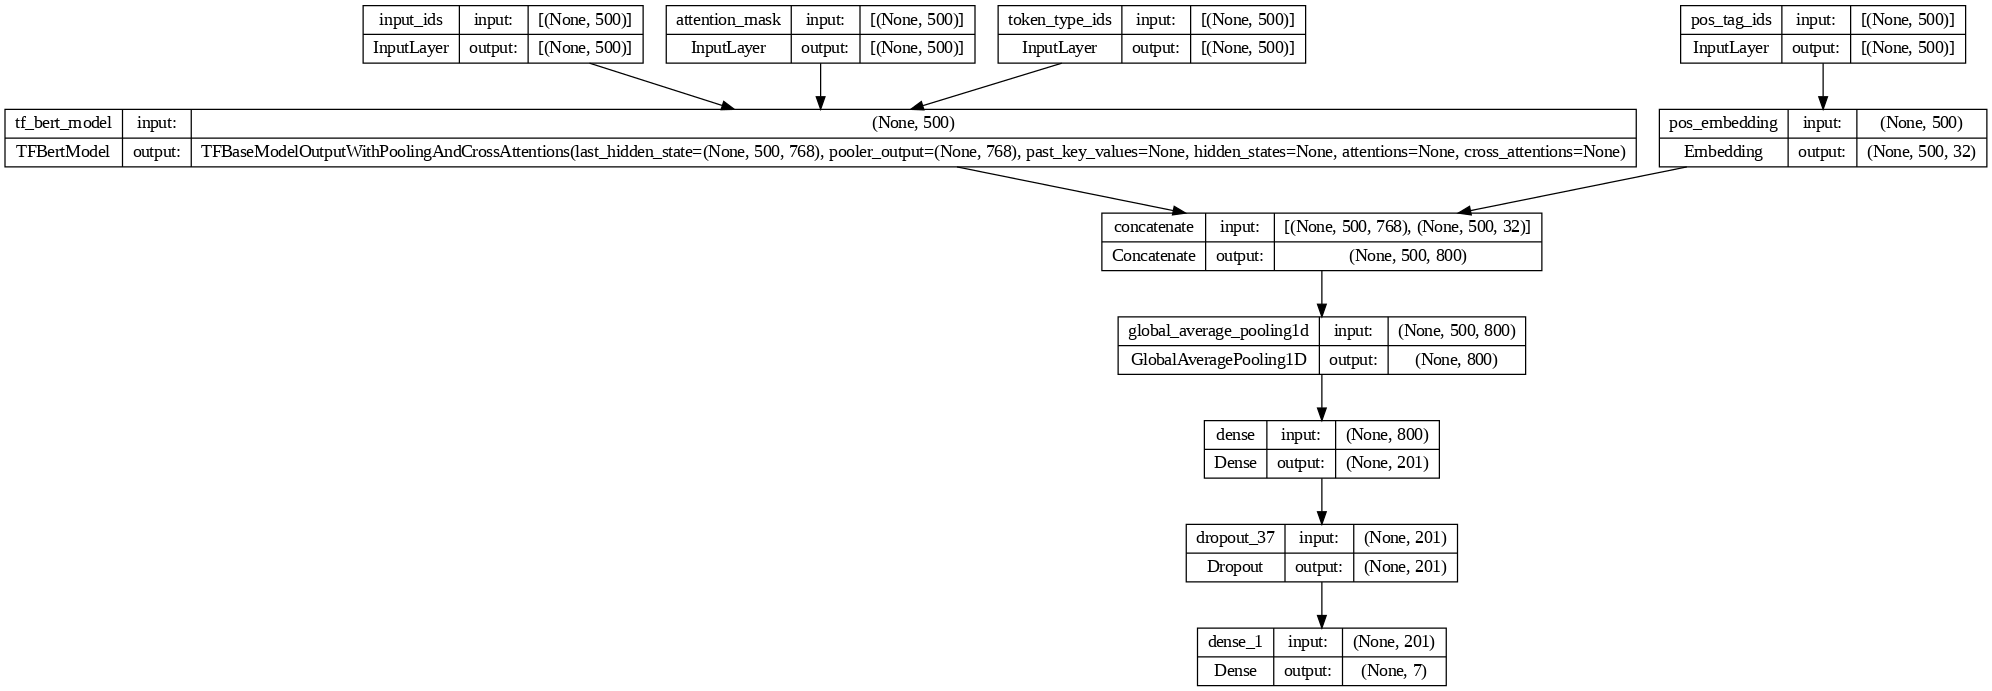

In [ ]:
model.summary()
keras.utils.plot_model(model, show_shapes=True, dpi=90)

### Error Analysis

In [ ]:
prior_window_size = 3
following_window_size = 3

# True labels from test set
y_true = y_test_encoded

# Map encoded labels back to original labels
true_labels = le.inverse_transform(y_true)
predicted_labels = le.inverse_transform(y_pred)

# Prepare test data with both prior and following utterances
# ensure that 'test_df' matches exactly the order in which test_inputs were created
test_context_texts, test_current_utterances, test_labels = prepare_data_with_full_context(
    test_df,
    prior_window_size=prior_window_size,
    following_window_size=following_window_size
)

# Create a DataFrame with context, current utterance, true and predicted labels
error_df = pd.DataFrame({
    'Context': test_context_texts,
    'Current_Utterance': test_current_utterances,
    'True_Label': true_labels,
    'Predicted_Label': predicted_labels
})

# Identify misclassified examples
misclassified_df = error_df[error_df['True_Label'] != error_df['Predicted_Label']]

# misclassified_df now contains misclassified instances along with their preceding and following utterances context.
print("Misclassified Examples:")
print(misclassified_df.head())


Misclassified Examples:
                                             Context  \
0  [PREV_3] [PAD] [PREV_2] [PAD] [PREV_1] [PAD] [...   
1  [PREV_3] [PAD] [PREV_2] [PAD] [PREV_1] Great. ...   
2  [PREV_3] [PAD] [PREV_2] Great. Great! Just giv...   
3  [PREV_3] Great. Great! Just give me a sec to c...   
4  [PREV_3] Okay. [PREV_2] Okay, I know I'm not s...   

                                   Current_Utterance      True_Label  \
0   Great. Great! Just give me a sec to change film.           Other   
1                                              Okay.   Monica Geller   
2  Okay, I know I'm not supposed to know, but I d...     Ross Geller   
3                             What? What's going on?  Joey Tribbiani   
4                                 Monica's pregnant!     Ross Geller   

  Predicted_Label  
0  Joey Tribbiani  
1   Chandler Bing  
2   Phoebe Buffay  
3    Rachel Green  
4   Phoebe Buffay  


In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
misclassified_df.head(100)

,Context,Current_Utterance,True_Label,Predicted_Label
0,"[PREV_3] [PAD] [PREV_2] [PAD] [PREV_1] [PAD] [NEXT_1] Okay. [NEXT_2] Okay, I know I'm not supposed to know, but I do. And I'm so excited for you! [NEXT_3] What? What's going on?",Great. Great! Just give me a sec to change film.,Other,Joey Tribbiani
1,"[PREV_3] [PAD] [PREV_2] [PAD] [PREV_1] Great. Great! Just give me a sec to change film. [NEXT_1] Okay, I know I'm not supposed to know, but I do. And I'm so excited for you! [NEXT_2] What? What's going on? [NEXT_3] Monica's pregnant!",Okay.,Monica Geller,Chandler Bing
2,[PREV_3] [PAD] [PREV_2] Great. Great! Just give me a sec to change film. [PREV_1] Okay. [NEXT_1] What? What's going on? [NEXT_2] Monica's pregnant! [NEXT_3] Oh my God! Is that why you guys had to get married?!,"Okay, I know I'm not supposed to know, but I do. And I'm so excited for you!",Ross Geller,Phoebe Buffay
3,"[PREV_3] Great. Great! Just give me a sec to change film. [PREV_2] Okay. [PREV_1] Okay, I know I'm not supposed to know, but I do. And I'm so excited for you! [NEXT_1] Monica's pregnant! [NEXT_2] Oh my God! Is that why you guys had to get married?! [NEXT_3] Guys! I'm not pregnant.",What? What's going on?,Joey Tribbiani,Rachel Green
4,"[PREV_3] Okay. [PREV_2] Okay, I know I'm not supposed to know, but I do. And I'm so excited for you! [PREV_1] What? What's going on? [NEXT_1] Oh my God! Is that why you guys had to get married?! [NEXT_2] Guys! I'm not pregnant. [NEXT_3] Ah. Slow swimmers?",Monica's pregnant!,Ross Geller,Phoebe Buffay
5,"[PREV_3] Okay, I know I'm not supposed to know, but I do. And I'm so excited for you! [PREV_2] What? What's going on? [PREV_1] Monica's pregnant! [NEXT_1] Guys! I'm not pregnant. [NEXT_2] Ah. Slow swimmers? [NEXT_3] What?! What do you mean? You-you-you're not pregnant?",Oh my God! Is that why you guys had to get married?!,Joey Tribbiani,Rachel Green
6,[PREV_3] What? What's going on? [PREV_2] Monica's pregnant! [PREV_1] Oh my God! Is that why you guys had to get married?! [NEXT_1] Ah. Slow swimmers? [NEXT_2] What?! What do you mean? You-you-you're not pregnant? [NEXT_3] You didn't tell anybody I was did you?!,Guys! I'm not pregnant.,Monica Geller,Rachel Green
7,[PREV_3] Monica's pregnant! [PREV_2] Oh my God! Is that why you guys had to get married?! [PREV_1] Guys! I'm not pregnant. [NEXT_1] What?! What do you mean? You-you-you're not pregnant? [NEXT_2] You didn't tell anybody I was did you?! [NEXT_3] No! I'll be right back.,Ah. Slow swimmers?,Joey Tribbiani,Chandler Bing
8,[PREV_3] Oh my God! Is that why you guys had to get married?! [PREV_2] Guys! I'm not pregnant. [PREV_1] Ah. Slow swimmers? [NEXT_1] You didn't tell anybody I was did you?! [NEXT_2] No! I'll be right back. [NEXT_3] Now why don't we get a shot of just Monica and the bloody soldier.,What?! What do you mean? You-you-you're not pregnant?,Ross Geller,Monica Geller
9,"[PREV_3] Guys! I'm not pregnant. [PREV_2] Ah. Slow swimmers? [PREV_1] What?! What do you mean? You-you-you're not pregnant? [NEXT_1] No! I'll be right back. [NEXT_2] Now why don't we get a shot of just Monica and the bloody soldier. [NEXT_3] Oh, about that. Joey, you have to change before the party.",You didn't tell anybody I was did you?!,Monica Geller,Chandler Bing


In [ ]:
error_df = pd.DataFrame({
    'season_id': test_df['season_id'].values,
    'episode_id': test_df['episode_id'].values,
    'Context': test_context_texts,
    'Current_Utterance': test_current_utterances,
    'True_Label': true_labels,
    'Predicted_Label': predicted_labels
})

misclassified_df = error_df[error_df['True_Label'] != error_df['Predicted_Label']]


In [ ]:
misclassified_df.head(100)

,season_id,episode_id,Context,Current_Utterance,True_Label,Predicted_Label
0,s08,e01,"[PREV_3] [PAD] [PREV_2] [PAD] [PREV_1] [PAD] [NEXT_1] Okay. [NEXT_2] Okay, I know I'm not supposed to know, but I do. And I'm so excited for you! [NEXT_3] What? What's going on?",Great. Great! Just give me a sec to change film.,Other,Joey Tribbiani
1,s08,e01,"[PREV_3] [PAD] [PREV_2] [PAD] [PREV_1] Great. Great! Just give me a sec to change film. [NEXT_1] Okay, I know I'm not supposed to know, but I do. And I'm so excited for you! [NEXT_2] What? What's going on? [NEXT_3] Monica's pregnant!",Okay.,Monica Geller,Chandler Bing
2,s08,e01,[PREV_3] [PAD] [PREV_2] Great. Great! Just give me a sec to change film. [PREV_1] Okay. [NEXT_1] What? What's going on? [NEXT_2] Monica's pregnant! [NEXT_3] Oh my God! Is that why you guys had to get married?!,"Okay, I know I'm not supposed to know, but I do. And I'm so excited for you!",Ross Geller,Phoebe Buffay
3,s08,e01,"[PREV_3] Great. Great! Just give me a sec to change film. [PREV_2] Okay. [PREV_1] Okay, I know I'm not supposed to know, but I do. And I'm so excited for you! [NEXT_1] Monica's pregnant! [NEXT_2] Oh my God! Is that why you guys had to get married?! [NEXT_3] Guys! I'm not pregnant.",What? What's going on?,Joey Tribbiani,Rachel Green
4,s08,e01,"[PREV_3] Okay. [PREV_2] Okay, I know I'm not supposed to know, but I do. And I'm so excited for you! [PREV_1] What? What's going on? [NEXT_1] Oh my God! Is that why you guys had to get married?! [NEXT_2] Guys! I'm not pregnant. [NEXT_3] Ah. Slow swimmers?",Monica's pregnant!,Ross Geller,Phoebe Buffay
5,s08,e01,"[PREV_3] Okay, I know I'm not supposed to know, but I do. And I'm so excited for you! [PREV_2] What? What's going on? [PREV_1] Monica's pregnant! [NEXT_1] Guys! I'm not pregnant. [NEXT_2] Ah. Slow swimmers? [NEXT_3] What?! What do you mean? You-you-you're not pregnant?",Oh my God! Is that why you guys had to get married?!,Joey Tribbiani,Rachel Green
6,s08,e01,[PREV_3] What? What's going on? [PREV_2] Monica's pregnant! [PREV_1] Oh my God! Is that why you guys had to get married?! [NEXT_1] Ah. Slow swimmers? [NEXT_2] What?! What do you mean? You-you-you're not pregnant? [NEXT_3] You didn't tell anybody I was did you?!,Guys! I'm not pregnant.,Monica Geller,Rachel Green
7,s08,e01,[PREV_3] Monica's pregnant! [PREV_2] Oh my God! Is that why you guys had to get married?! [PREV_1] Guys! I'm not pregnant. [NEXT_1] What?! What do you mean? You-you-you're not pregnant? [NEXT_2] You didn't tell anybody I was did you?! [NEXT_3] No! I'll be right back.,Ah. Slow swimmers?,Joey Tribbiani,Chandler Bing
8,s08,e01,[PREV_3] Oh my God! Is that why you guys had to get married?! [PREV_2] Guys! I'm not pregnant. [PREV_1] Ah. Slow swimmers? [NEXT_1] You didn't tell anybody I was did you?! [NEXT_2] No! I'll be right back. [NEXT_3] Now why don't we get a shot of just Monica and the bloody soldier.,What?! What do you mean? You-you-you're not pregnant?,Ross Geller,Monica Geller
9,s08,e01,"[PREV_3] Guys! I'm not pregnant. [PREV_2] Ah. Slow swimmers? [PREV_1] What?! What do you mean? You-you-you're not pregnant? [NEXT_1] No! I'll be right back. [NEXT_2] Now why don't we get a shot of just Monica and the bloody soldier. [NEXT_3] Oh, about that. Joey, you have to change before the party.",You didn't tell anybody I was did you?!,Monica Geller,Chandler Bing


In [ ]:
# Group by season and episode
grouped = error_df.groupby(['season_id', 'episode_id'])

# Calculate accuracy per group
acc_by_episode = grouped.apply(lambda g: (g['True_Label'] == g['Predicted_Label']).mean())

# Convert to a DataFrame for better readability
acc_by_episode_df = acc_by_episode.reset_index(name='accuracy')

print(acc_by_episode_df)


   season_id episode_id  accuracy
0        s08        e01  0.367857
1        s08        e02  0.372694
2        s08        e03  0.376812
3        s08        e04  0.358209
4        s08        e05  0.420000
5        s08        e06  0.372881
6        s08        e07  0.369403
7        s08        e08  0.457692
8        s08        e09  0.391144
9        s08        e10  0.374545
10       s08        e11  0.359307
11       s08        e12  0.402655
12       s08        e13  0.366300
13       s08        e14  0.463035
14       s08        e15  0.377119
15       s08        e16  0.415179
16       s08        e17  0.470852
17       s08        e18  0.319149
18       s08        e19  0.481013
19       s08        e20  0.397260
20       s08        e21  0.467681
21       s08        e22  0.326180
22       s08        e23  0.418803
23       s08        e24  0.421233


<ipython-input-53-0cc4f2740bcf>:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_by_episode = grouped.apply(lambda g: (g['True_Label'] == g['Predicted_Label']).mean())


## 4.6 BERT + Context (-3, EP) + Syntax
BERT model with a context window of three preceding utterances from the same episode, augmented with syntactic features.

#### Prepare context features

##### Prepare data with context

In [ ]:
def split_data_by_season(df):
    """Splits data into train, validation, and test sets based on season.

    Args:
        df: Pandas DataFrame with 'season_id', 'episode_id', 'transcript', and 'speaker' columns.

    Returns:
        train_df, val_df, test_df: DataFrames for training, validation, and test sets.
    """
    train_df = df[df['season_id'].isin(['s01', 's02', 's03', 's04', 's05', 's06'])]
    val_df = df[df['season_id'] == 's07']
    test_df = df[df['season_id'] == 's08']

    return train_df, val_df, test_df


In [ ]:
def prepare_data_with_context(df, context_window_size):
    context_texts = []
    current_utterances = []
    labels = []
    for i in range(len(df)):
        context = []
        current_episode_id = df.iloc[i]['episode_id']
        current_season_id = df.iloc[i]['season_id']
        # Collect previous utterances as context
        for j in range(context_window_size, 0, -1):
            idx = i - j
            if idx >= 0:
                prev_row = df.iloc[idx]
                # Check if the previous utterance is in the same episode and season
                if (prev_row['episode_id'] == current_episode_id and
                    prev_row['season_id'] == current_season_id):
                    context.append(prev_row['transcript'])
                else:
                    # If not the same episode, pad with [PAD]
                    context.append('[PAD]')
            else:
                # If index is out of bounds, pad with [PAD]
                context.append('[PAD]')
        # Join context utterances
        context_text = ' [SEP] '.join(context)
        # Current utterance
        current_utterance = df.iloc[i]['transcript']
        # Append to lists
        context_texts.append(context_text)
        current_utterances.append(current_utterance)
        labels.append(df.iloc[i]['speaker'])
    return context_texts, current_utterances, labels


In [ ]:
train_df, val_df, test_df = split_data_by_season(df)


In [ ]:
context_window_size = 3  # Example window size
train_context_texts, train_current_utterances, train_labels = prepare_data_with_context(train_df, context_window_size)
val_context_texts, val_current_utterances, val_labels = prepare_data_with_context(val_df, context_window_size)
test_context_texts, test_current_utterances, test_labels = prepare_data_with_context(test_df, context_window_size)


In [ ]:
# Check output.
for i in range(4):
  print(train_context_texts[i])
  print("------------Current Utterance---------")
  print(train_current_utterances[i])
  print("------------Next Example---------")
  print('\n')

[PAD] [SEP] [PAD] [SEP] [PAD]
------------Current Utterance---------
There's nothing to tell! He's just some guy I work with!
------------Next Example---------


[PAD] [SEP] [PAD] [SEP] There's nothing to tell! He's just some guy I work with!
------------Current Utterance---------
C'mon, you're going out with the guy! There's gotta be something wrong with him!
------------Next Example---------


[PAD] [SEP] There's nothing to tell! He's just some guy I work with! [SEP] C'mon, you're going out with the guy! There's gotta be something wrong with him!
------------Current Utterance---------
All right Joey, be nice. So does he have a hump? A hump and a hairpiece?
------------Next Example---------


There's nothing to tell! He's just some guy I work with! [SEP] C'mon, you're going out with the guy! There's gotta be something wrong with him! [SEP] All right Joey, be nice. So does he have a hump? A hump and a hairpiece?
------------Current Utterance---------
Wait, does he eat chalk?
----------

In [ ]:
# Reset index to ensure alignment
train_df = train_df.reset_index(drop=True)

In [ ]:
# Create a unique episode identifier
train_df['season_episode_id'] = train_df['season_id'] + '_' + train_df['episode_id']

# Group the DataFrame by 'season_episode_id'
grouped = train_df.groupby('season_episode_id')

# Dictionary to store first and last indices for each episode
episode_first_last_indices = {}

for episode_id, group in grouped:
    first_index = group.index[0]
    last_index = group.index[-1]
    episode_first_last_indices[episode_id] = (first_index, last_index)


##### Confirm context for beginning and end utterances

In [ ]:
first_utterances = []
last_utterances = []

for episode_id, (first_idx, last_idx) in episode_first_last_indices.items():
    # Extract the first utterance and its context
    first_utterance = {
        'season_episode_id': episode_id,
        'season_id': train_df.loc[first_idx, 'season_id'],
        'episode_id': train_df.loc[first_idx, 'episode_id'],
        'speaker': train_df.loc[first_idx, 'speaker'],
        'utterance': train_current_utterances[first_idx],
        'context': train_context_texts[first_idx]
    }
    first_utterances.append(first_utterance)

    # Extract the last utterance and its context
    last_utterance = {
        'season_episode_id': episode_id,
        'season_id': train_df.loc[last_idx, 'season_id'],
        'episode_id': train_df.loc[last_idx, 'episode_id'],
        'speaker': train_df.loc[last_idx, 'speaker'],
        'utterance': train_current_utterances[last_idx],
        'context': train_context_texts[last_idx]
    }
    last_utterances.append(last_utterance)

# Convert lists to DataFrames
first_utterances_df = pd.DataFrame(first_utterances)
last_utterances_df = pd.DataFrame(last_utterances)



In [ ]:
# View first utterances
first_utterances_df.head()

# View last utterances
last_utterances_df.head()


,season_episode_id,season_id,episode_id,speaker,utterance,context
0,s01_e01,s01,e01,Chandler Bing,"Okay, so, I'm in Las Vegas... I'm Liza Minelli-","Kids, new dream... I'm in Las Vegas. [SEP] Ahh, miss? More coffee? [SEP] Ugh. Excuse me, could you give this to that guy over there? Go ahead. Thank you. Sorry. Okay, Las Vegas."
1,s01_e02,s01,e02,Rachel Green,"Hi, Mindy. Hi, it-it's Rachel. Yeah, I'm fine. I-I saw Barry today. Oh, yeah, yeah he-he told me. No, no, it's okay. I hope you two are very happy, I really do. Oh, oh, and Mind, y'know, if-if everything works out, and you guys end up getting married and having kids- and everything- I just hope they have his old hairline and your old nose. Okay, I know it was a cheap shot, but I feel so much better now.",Am not! [SEP] You're gonna be an aunt. [SEP] Oh shut up!
2,s01_e03,s01,e03,Chandler Bing,"Yeah, alright.","No no no! [SEP] I don't care, I don't care! Game's over! I'm weak! I've gotta smoke! I've gotta have the smoke! [SEP] If you never smoke again I'll give you seven thousand dollars!"
3,s01_e04,s01,e04,Rachel Green,Ohhh... I'm fine.,"Green. To the green. [SEP] I've got magic beans. Never-never mind. [SEP] To the left, to the left- aww!"
4,s01_e05,s01,e05,Phoebe Buffay,That oughta do it.,"Where's Chandler? [SEP] Oh, he needed some time to grieve. [SEP] I'm free! I'm free!"


##### Tokenize context features

In [ ]:
model_checkpoint = 'bert-base-cased'
tokenizer = BertTokenizerFast.from_pretrained(model_checkpoint)
max_length = 500  # close to BERT max

Downloading:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
def tokenize_texts(texts, text_pairs, tokenizer, max_length):
    return tokenizer(
        text=texts,
        text_pair=text_pairs,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='tf',
        return_token_type_ids=True  # Ensure token_type_ids are returned
    )


In [ ]:
# Tokenize training data
train_encodings = tokenize_texts(
    texts=train_context_texts,
    text_pairs=train_current_utterances,
    tokenizer=tokenizer,
    max_length=max_length
)

# Tokenize validation data
val_encodings = tokenize_texts(
    texts=val_context_texts,
    text_pairs=val_current_utterances,
    tokenizer=tokenizer,
    max_length=max_length
)

# Tokenize test data
test_encodings = tokenize_texts(
    texts=test_context_texts,
    text_pairs=test_current_utterances,
    tokenizer=tokenizer,
    max_length=max_length
)


In [ ]:
attention_masks = train_encodings['attention_mask'].numpy()
sequence_lengths = attention_masks.sum(axis=1)

print("Sequence lengths:", sequence_lengths)


Sequence lengths: [25 47 69 ... 51 55 43]


#### spaCy and Dependency Parsing

In [ ]:
def extract_syntactic_features(texts, nlp):
    all_pos_tags = []
    all_dep_labels = []

    for text in texts:
        doc = nlp(text)
        pos_tags = [token.pos_ for token in doc]
        dep_labels = [token.dep_ for token in doc]
        all_pos_tags.append(pos_tags)
        all_dep_labels.append(dep_labels)

    return all_pos_tags, all_dep_labels

In [ ]:
# Extract syntactic features for context texts
train_context_pos_tags, train_context_dep_labels = extract_syntactic_features(train_context_texts, nlp)
val_context_pos_tags, val_context_dep_labels = extract_syntactic_features(val_context_texts, nlp)
test_context_pos_tags, test_context_dep_labels = extract_syntactic_features(test_context_texts, nlp)

# Extract syntactic features for current utterances
train_current_pos_tags, train_current_dep_labels = extract_syntactic_features(train_current_utterances, nlp)
val_current_pos_tags, val_current_dep_labels = extract_syntactic_features(val_current_utterances, nlp)
test_current_pos_tags, test_current_dep_labels = extract_syntactic_features(test_current_utterances, nlp)


In [ ]:
def tokenize_texts_with_alignment(texts, text_pairs, tokenizer, max_length):
    input_ids = []
    attention_masks = []
    token_type_ids = []
    offset_mappings = []

    for text, text_pair in zip(texts, text_pairs):
        encoding = tokenizer.encode_plus(
            text=text,
            text_pair=text_pair,
            truncation=True,
            padding='max_length',
            max_length=max_length,
            return_tensors='tf',
            return_token_type_ids=True,
            return_offsets_mapping=True  # Get offset mappings
        )
        input_ids.append(encoding['input_ids'])
        attention_masks.append(encoding['attention_mask'])
        token_type_ids.append(encoding['token_type_ids'])
        offset_mappings.append(encoding['offset_mapping'])

    # Stack tensors
    input_ids = tf.concat(input_ids, axis=0)
    attention_masks = tf.concat(attention_masks, axis=0)
    token_type_ids = tf.concat(token_type_ids, axis=0)
    offset_mappings = [mapping.numpy() for mapping in offset_mappings]

    return {
        'input_ids': input_ids,
        'attention_mask': attention_masks,
        'token_type_ids': token_type_ids,
        'offset_mappings': offset_mappings
    }


In [ ]:
def align_spacy_and_bert_tokens(spacy_tokens, bert_offsets):
    aligned_tags = []
    spacy_idx = 0
    spacy_token = spacy_tokens[spacy_idx]

    for bert_offset in bert_offsets:
        start, end = bert_offset
        if start == end:
            # Special tokens (e.g., [CLS], [SEP], padding)
            aligned_tags.append('O')  # Or a special tag
            continue
        bert_token_text = text[start:end]
        # Align spaCy token with BERT token
        if bert_token_text.lower() == spacy_token.text.lower():
            aligned_tags.append(spacy_token.pos_)
            spacy_idx += 1
            if spacy_idx < len(spacy_tokens):
                spacy_token = spacy_tokens[spacy_idx]
        else:
            # Handle subword tokens
            aligned_tags.append(spacy_token.pos_)
    return aligned_tags


In [ ]:
def get_aligned_pos_tags(offset_mapping, spacy_doc):
    pos_tags = []
    spacy_tokens = list(spacy_doc)
    spacy_idx = 0

    for offset in offset_mapping:
        start, end = offset
        if start == end:
            # Special tokens
            pos_tags.append('O')
            continue
        while spacy_idx < len(spacy_tokens) and spacy_tokens[spacy_idx].idx < start:
            spacy_idx += 1
        if spacy_idx < len(spacy_tokens):
            pos_tags.append(spacy_tokens[spacy_idx].pos_)
        else:
            pos_tags.append('O')
    return pos_tags


In [ ]:
def process_and_align_syntactic_features(texts, text_pairs, tokenizer, nlp, max_length):
    encodings = tokenizer(
        texts,
        text_pair=text_pairs,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='tf',
        return_token_type_ids=True,
        return_offsets_mapping=True
    )

    input_ids = encodings['input_ids']
    attention_mask = encodings['attention_mask']
    token_type_ids = encodings['token_type_ids']
    offset_mappings = encodings['offset_mapping'].numpy()

    all_pos_tags = []

    for i in range(len(texts)):
        text = texts[i] if text_pairs is None else texts[i] + ' ' + text_pairs[i]
        doc = nlp(text)
        pos_tags = get_aligned_pos_tags(offset_mappings[i], doc)
        all_pos_tags.append(pos_tags)

    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'token_type_ids': token_type_ids,
        'pos_tags': all_pos_tags
    }


In [ ]:
def convert_pos_tags_to_ids(pos_tags_list, pos_tag2id):
    pos_tag_ids_list = []
    for pos_tags in pos_tags_list:
        pos_tag_ids = [pos_tag2id.get(tag, pos_tag2id['O']) for tag in pos_tags]
        pos_tag_ids_list.append(pos_tag_ids)
    return pos_tag_ids_list

# For training data
train_pos_tag_ids = convert_pos_tags_to_ids(train_encodings['pos_tags'], pos_tag2id)


In [ ]:
# Tokenize training data with alignment
train_encodings = tokenize_texts_with_alignment(
    texts=train_context_texts,
    text_pairs=train_current_utterances,
    tokenizer=tokenizer,
    max_length=max_length
)

In [ ]:
# For training data
train_encodings = process_and_align_syntactic_features(
    texts=train_context_texts,
    text_pairs=train_current_utterances,
    tokenizer=tokenizer,
    nlp=nlp,
    max_length=max_length
)


In [ ]:
# Collect all POS tags from the dataset
pos_tag_set = set()
for pos_tags in train_encodings['pos_tags']:
    pos_tag_set.update(pos_tags)

pos_tag2id = {tag: idx for idx, tag in enumerate(sorted(pos_tag_set))}
id2pos_tag = {idx: tag for tag, idx in pos_tag2id.items()}


In [ ]:
train_pos_tag_ids = tf.constant(train_pos_tag_ids)

In [ ]:
# Process and align syntactic features for validation data
val_encodings = process_and_align_syntactic_features(
    texts=val_context_texts,
    text_pairs=val_current_utterances,
    tokenizer=tokenizer,
    nlp=nlp,
    max_length=max_length
)

# Convert POS tags to IDs for validation data
val_pos_tag_ids = convert_pos_tags_to_ids(val_encodings['pos_tags'], pos_tag2id)
val_pos_tag_ids = tf.constant(val_pos_tag_ids)

# Prepare validation inputs
val_inputs = {
    'input_ids': val_encodings['input_ids'],
    'token_type_ids': val_encodings['token_type_ids'],
    'attention_mask': val_encodings['attention_mask'],
    'pos_tag_ids': val_pos_tag_ids
}


In [ ]:
# Process and align syntactic features for test data
test_encodings = process_and_align_syntactic_features(
    texts=test_context_texts,
    text_pairs=test_current_utterances,
    tokenizer=tokenizer,
    nlp=nlp,
    max_length=max_length
)

# Convert POS tags to IDs for test data
test_pos_tag_ids = convert_pos_tags_to_ids(test_encodings['pos_tags'], pos_tag2id)
test_pos_tag_ids = tf.constant(test_pos_tag_ids)

# Prepare test inputs
test_inputs = {
    'input_ids': test_encodings['input_ids'],
    'token_type_ids': test_encodings['token_type_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'pos_tag_ids': test_pos_tag_ids
}


### Model Definition

In [ ]:
def build_bert_multiclass_model(num_classes, max_length, pos_tag_vocab_size):
    """Builds a multi-class text classification model using BERT with context windows.

    Args:
        num_classes: The number of output classes (speakers).
        max_length: The maximum sequence length.

    Returns:
        A compiled Keras model.
    """

    # Load pre-trained BERT model
    bert_model = TFBertModel.from_pretrained('bert-base-cased')

    # Enable fine-tuning of BERT weights
    bert_model.trainable = True

    # Input Layers
    input_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="input_ids")
    token_type_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="token_type_ids")
    attention_mask = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="attention_mask")
    pos_tag_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="pos_tag_ids")

    # POS Tag Embedding Layer
    pos_embedding_dim = 32
    pos_embedding = tf.keras.layers.Embedding(
        input_dim=pos_tag_vocab_size,
        output_dim=pos_embedding_dim,
        input_length=max_length,
        name='pos_embedding'
    )(pos_tag_ids)

    # BERT Layer
    bert_outputs = bert_model(
        input_ids=input_ids,
        token_type_ids=token_type_ids,
        attention_mask=attention_mask
    )

    # Combine BERT embeddings with POS embeddings
    sequence_output = bert_outputs.last_hidden_state  # Shape: (batch_size, max_length, hidden_size)
    combined_embeddings = tf.keras.layers.concatenate([sequence_output, pos_embedding], axis=-1)

    # Global Average Pooling
    pooled_output = tf.keras.layers.GlobalAveragePooling1D()(combined_embeddings)

    # Dense Layer
    hidden = tf.keras.layers.Dense(201, activation="relu")(pooled_output)

    # Dropout Layer
    dropout = tf.keras.layers.Dropout(0.3)(hidden)

    # Classification Layer
    classification_output = tf.keras.layers.Dense(
        num_classes, activation="softmax")(dropout)

    # Create the Keras model
    model = tf.keras.Model(
        inputs=[input_ids, token_type_ids, attention_mask, pos_tag_ids],
        outputs=classification_output
    )

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model


### Callbacks and Random Seeds

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=1,
    min_lr=1e-6
)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


### Model Training

In [ ]:
# Determine POS tag vocabulary size
pos_tag_vocab_size = len(pos_tag2id)

# Determine the number of speakers
num_speakers = len(np.unique(y_train_encoded))

# Build the model
model = build_bert_multiclass_model(num_speakers, max_length, pos_tag_vocab_size)

# Train the model
history = model.fit(
    x={
        'input_ids': train_encodings['input_ids'],
        'token_type_ids': train_encodings['token_type_ids'],
        'attention_mask': train_encodings['attention_mask'],
        'pos_tag_ids': train_pos_tag_ids
    },
    y=y_train_encoded,
    validation_data=(
        {
            'input_ids': val_encodings['input_ids'],
            'token_type_ids': val_encodings['token_type_ids'],
            'attention_mask': val_encodings['attention_mask'],
            'pos_tag_ids': val_pos_tag_ids
        },
        y_val_encoded
    ),
    epochs=5,
    batch_size=16,
    callbacks=[early_stopping, reduce_lr]
)


Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/5


2326/2326 [==============================] - 685s 276ms/step - loss: 1.8170 - accuracy: 0.2729 - val_loss: 1.7286 - val_accuracy: 0.3286 - lr: 2.0000e-05
Epoch 2/5
2326/2326 [==============================] - 636s 274ms/step - loss: 1.6056 - accuracy: 0.3870 - val_loss: 1.6944 - val_accuracy: 0.3494 - lr: 2.0000e-05
Epoch 3/5
2326/2326 [==============================] - 635s 273ms/step - loss: 1.3348 - accuracy: 0.4933 - val_loss: 1.8207 - val_accuracy: 0.3524 - lr: 2.0000e-05
Epoch 4/5
2326/2326 [==============================] - 635s 273ms/step - loss: 0.9109 - accuracy: 0.6620 - val_loss: 2.0674 - val_accuracy: 0.3487 - lr: 1.0000e-05


### Model Evaluation

In [ ]:
# Evaluate the model
_, test_accuracy = model.evaluate(
    x={
        'input_ids': test_encodings['input_ids'],
        'token_type_ids': test_encodings['token_type_ids'],
        'attention_mask': test_encodings['attention_mask'],
        'pos_tag_ids': test_pos_tag_ids
    },
    y=y_test_encoded
)
print(f"Test Accuracy: {test_accuracy}")

# Additional evaluation (per-class metrics)
from sklearn.metrics import classification_report

y_pred_probs = model.predict(
    x={
        'input_ids': test_encodings['input_ids'],
        'token_type_ids': test_encodings['token_type_ids'],
        'attention_mask': test_encodings['attention_mask'],
        'pos_tag_ids': test_pos_tag_ids
    }
)
y_pred = np.argmax(y_pred_probs, axis=1)
print(classification_report(y_test_encoded, y_pred, target_names=le.classes_))


195/195 [==============================] - 33s 167ms/step - loss: 1.7337 - accuracy: 0.3432
Test Accuracy: 0.34324759244918823
195/195 [==============================] - 35s 163ms/step
                precision    recall  f1-score   support

 Chandler Bing       0.27      0.33      0.30       677
Joey Tribbiani       0.44      0.39      0.41       909
 Monica Geller       0.28      0.25      0.26       812
         Other       0.34      0.54      0.42       979
 Phoebe Buffay       0.29      0.32      0.30       773
  Rachel Green       0.36      0.31      0.33      1086
   Ross Geller       0.52      0.24      0.32       984

      accuracy                           0.34      6220
     macro avg       0.36      0.34      0.34      6220
  weighted avg       0.36      0.34      0.34      6220



In [ ]:
keys = test_encodings.keys()
print(keys)

dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'pos_tags'])


### Confusion Matrix

In [ ]:
def create_and_plot_confusion_matrix(y_true, y_pred, target_names):
    """Creates and plots a confusion matrix.

    Args:
        y_true: True labels (NumPy array).
        y_pred: Predicted labels (NumPy array).
        target_names: List of class names (strings).
    """

    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # Normalize for percentages

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm_normalized,
        annot=True,
        fmt=".2f",  # Format numbers to two decimal places
        xticklabels=target_names,
        yticklabels=target_names,
        cmap="Blues",
    )
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title("Confusion Matrix (Normalized)")
    plt.show()


create_and_plot_confusion_matrix(y_test_encoded, y_pred, le.classes_)

### Model Summary

In [ ]:
model.summary()
keras.utils.plot_model(model, show_shapes=True, dpi=90)

### Error Analysis

In [ ]:
y_true = y_test_encoded  # True labels

# Map encoded labels back to original labels
true_labels = le.inverse_transform(y_true)
predicted_labels = le.inverse_transform(y_pred)

# Get the test utterances and context
test_utterances = x_test  # Original test utterances
test_context_texts, test_current_utterances, _ = prepare_data_with_context(
    x_test, y_test, context_window_size
)

# Create a DataFrame with the results
error_df = pd.DataFrame({
    'Context': test_context_texts,
    'Current_Utterance': test_current_utterances,
    'True_Label': true_labels,
    'Predicted_Label': predicted_labels
})

# Identify misclassified examples
misclassified_df = error_df[error_df['True_Label'] != error_df['Predicted_Label']]

In [ ]:
# Set pandas option to display full text
pd.set_option('display.max_colwidth', None)

In [ ]:
misclassified_df

In [ ]:
pd.set_option('display.max_rows', 100)

In [ ]:
print(misclassified_df)

In [ ]:
misclassified_df

## 4.4 BERT + Context (-1, 2, 4, 6)

In [ ]:
# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Initialize tokenizer and model parameters
model_checkpoint = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
max_length = 512  # BERT max length

# Define early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=1,
    min_lr=1e-6
)

# Function to train and evaluate the model with a given context window size
def train_and_evaluate(context_window_size, x_train, y_train, x_val, y_val, x_test, y_test, y_train_encoded, y_val_encoded, y_test_encoded, le, max_length, num_speakers):
    # Prepare data with the given context window size
    train_context_texts, train_current_utterances, y_train = prepare_data_with_context(
        x_train, y_train, context_window_size)
    val_context_texts, val_current_utterances, y_val = prepare_data_with_context(
        x_val, y_val, context_window_size)
    test_context_texts, test_current_utterances, y_test = prepare_data_with_context(
        x_test, y_test, context_window_size)

    # Tokenize the data
    train_encodings = tokenize_texts(
        texts=train_context_texts,
        text_pairs=train_current_utterances,
        tokenizer=tokenizer,
        max_length=max_length
    )
    val_encodings = tokenize_texts(
        texts=val_context_texts,
        text_pairs=val_current_utterances,
        tokenizer=tokenizer,
        max_length=max_length
    )
    test_encodings = tokenize_texts(
        texts=test_context_texts,
        text_pairs=test_current_utterances,
        tokenizer=tokenizer,
        max_length=max_length
    )

    # Build the model
    model = build_bert_multiclass_model(num_speakers, max_length)

    # Train the model
    history = model.fit(
        x={
            'input_ids': train_encodings['input_ids'],
            'token_type_ids': train_encodings['token_type_ids'],
            'attention_mask': train_encodings['attention_mask']
        },
        y=y_train_encoded,
        validation_data=(
            {
                'input_ids': val_encodings['input_ids'],
                'token_type_ids': val_encodings['token_type_ids'],
                'attention_mask': val_encodings['attention_mask']
            },
            y_val_encoded
        ),
        epochs=1,
        batch_size=16,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    # Evaluate the model
    val_loss, val_accuracy = model.evaluate(
        x={
            'input_ids': val_encodings['input_ids'],
            'token_type_ids': val_encodings['token_type_ids'],
            'attention_mask': val_encodings['attention_mask']
        },
        y=y_val_encoded,
        verbose=0
    )

    # Evaluate on test data
    test_loss, test_accuracy = model.evaluate(
        x={
            'input_ids': test_encodings['input_ids'],
            'token_type_ids': test_encodings['token_type_ids'],
            'attention_mask': test_encodings['attention_mask']
        },
        y=y_test_encoded,
        verbose=0
    )

    return val_accuracy, test_accuracy

# List of context window sizes to test
context_window_sizes = [1,2,4,6]

results = []

for cws in context_window_sizes:
    print(f"\nTraining with context window size: {cws}")
    val_accuracy, test_accuracy = train_and_evaluate(
        context_window_size=cws,
        x_train=x_train,
        y_train=y_train,
        x_val=x_val,
        y_val=y_val,
        x_test=x_test,
        y_test=y_test,
        y_train_encoded=y_train_encoded,
        y_val_encoded=y_val_encoded,
        y_test_encoded=y_test_encoded,
        le=le,
        max_length=max_length,
        num_speakers=num_speakers
    )
    results.append({
        'context_window_size': cws,
        'val_accuracy': val_accuracy,
        'test_accuracy': test_accuracy
    })

# Analyze the results
results_df = pd.DataFrame(results)
print(results_df)



Training with context window size: 1


Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


2326/2326 [==============================] - 1092s 452ms/step - loss: 1.9112 - accuracy: 0.2072 - val_loss: 1.8122 - val_accuracy: 0.2783 - lr: 2.0000e-05

Training with context window size: 2


Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


2326/2326 [==============================] - 1090s 452ms/step - loss: 1.8916 - accuracy: 0.2234 - val_loss: 1.8038 - val_accuracy: 0.2830 - lr: 2.0000e-05

Training with context window size: 4


Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


2326/2326 [==============================] - 1093s 452ms/step - loss: 1.8684 - accuracy: 0.2395 - val_loss: 1.7742 - val_accuracy: 0.3096 - lr: 2.0000e-05

Training with context window size: 6


Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


1330/2326 [================>.............] - ETA: 7:05 - loss: 1.9368 - accuracy: 0.1845

In [ ]:
results_df

,context_window_size,val_accuracy,test_accuracy
0,1,0.278271,0.284566
1,2,0.283022,0.295177
2,4,0.309629,0.317846
3,6,0.312480,0.313344


## 4.3 BERT + Context (-3)
BERT model enhanced with a context window of three preceding utterances.

#### 4.3.0 BERT encodings [with Context]

##### Prepare data with context

In [ ]:
def prepare_data_with_context(utterances, labels, context_window_size):
    context_texts = []
    current_utterances = []
    new_labels = []
    for i in range(len(utterances)):
        context = []
        # Collect previous utterances as context
        for j in range(context_window_size, 0, -1):
            if i - j >= 0:
                context.append(utterances[i - j])
            else:
                context.append('[PAD]')
        # Join context utterances
        context_text = ' [SEP] '.join(context)
        # Current utterance
        current_utterance = utterances[i]
        # Append to lists
        context_texts.append(context_text)
        current_utterances.append(current_utterance)
        new_labels.append(labels[i])
    return context_texts, current_utterances, new_labels


In [ ]:
context_window_size = 3

# Prepare training data
train_context_texts, train_current_utterances, y_train = prepare_data_with_context(
    x_train, y_train, context_window_size)

# Prepare validation data
val_context_texts, val_current_utterances, y_val = prepare_data_with_context(
    x_val, y_val, context_window_size)

# Prepare test data
test_context_texts, test_current_utterances, y_test = prepare_data_with_context(
    x_test, y_test, context_window_size)


In [ ]:
# Check output.
for i in range(4):
  print(train_context_texts[i])
  print("------------Current Utterance---------")
  print(train_current_utterances[i])
  print("------------Next Example---------")
  print('\n')

[PAD] [SEP] [PAD] [SEP] [PAD]
------------Current Utterance---------
There's nothing to tell! He's just some guy I work with!
------------Next Example---------


[PAD] [SEP] [PAD] [SEP] There's nothing to tell! He's just some guy I work with!
------------Current Utterance---------
C'mon, you're going out with the guy! There's gotta be something wrong with him!
------------Next Example---------


[PAD] [SEP] There's nothing to tell! He's just some guy I work with! [SEP] C'mon, you're going out with the guy! There's gotta be something wrong with him!
------------Current Utterance---------
All right Joey, be nice. So does he have a hump? A hump and a hairpiece?
------------Next Example---------


There's nothing to tell! He's just some guy I work with! [SEP] C'mon, you're going out with the guy! There's gotta be something wrong with him! [SEP] All right Joey, be nice. So does he have a hump? A hump and a hairpiece?
------------Current Utterance---------
Wait, does he eat chalk?
----------

In [ ]:
# Check sample length
len(train_context_texts[4])

190

##### Tokeniziation with Context and Current Utterance

In [ ]:
model_checkpoint = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
max_length = 500  # close to BERT max

In [ ]:
def tokenize_texts(texts, text_pairs, tokenizer, max_length):
    return tokenizer(
        text=texts,
        text_pair=text_pairs,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='tf',
        return_token_type_ids=True  # Ensure token_type_ids are returned
    )


In [ ]:
# Tokenize training data
train_encodings = tokenize_texts(
    texts=train_context_texts,
    text_pairs=train_current_utterances,
    tokenizer=tokenizer,
    max_length=max_length
)

# Tokenize validation data
val_encodings = tokenize_texts(
    texts=val_context_texts,
    text_pairs=val_current_utterances,
    tokenizer=tokenizer,
    max_length=max_length
)

# Tokenize test data
test_encodings = tokenize_texts(
    texts=test_context_texts,
    text_pairs=test_current_utterances,
    tokenizer=tokenizer,
    max_length=max_length
)


In [ ]:
attention_masks = train_encodings['attention_mask'].numpy()
sequence_lengths = attention_masks.sum(axis=1)

print("Sequence lengths:", sequence_lengths)


Sequence lengths: [25 47 69 ... 51 55 43]


In [ ]:
max_length = np.max(sequence_lengths)
mean_length = np.mean(sequence_lengths)
median_length = np.median(sequence_lengths)
percentiles = np.percentile(sequence_lengths, [50, 75, 90, 95, 99])

print(f"Maximum sequence length: {max_length}")
print(f"Mean sequence length: {mean_length}")
print(f"Median sequence length: {median_length}")
print("Percentiles:")
print("50th percentile (median):", percentiles[0])
print("75th percentile:", percentiles[1])
print("90th percentile:", percentiles[2])
print("95th percentile:", percentiles[3])
print("99th percentile:", percentiles[4])


Maximum sequence length: 311
Mean sequence length: 66.65662375359476
Median sequence length: 61.0
Percentiles:
50th percentile (median): 61.0
75th percentile: 83.0
90th percentile: 108.0
95th percentile: 128.0
99th percentile: 170.0


Context Segment Lengths:
Max: 292
Mean: 50.24221248689763
Median: 44.0
Percentiles:
50th percentile (median): 44.0
75th percentile: 63.0
90th percentile: 85.0
95th percentile: 102.0
99th percentile: 141.0

Current Utterance Segment Lengths:
Max: 246
Mean: 16.414411266697126
Median: 12.0
Percentiles:
50th percentile (median): 12.0
75th percentile: 21.0
90th percentile: 34.0
95th percentile: 45.0
99th percentile: 74.0


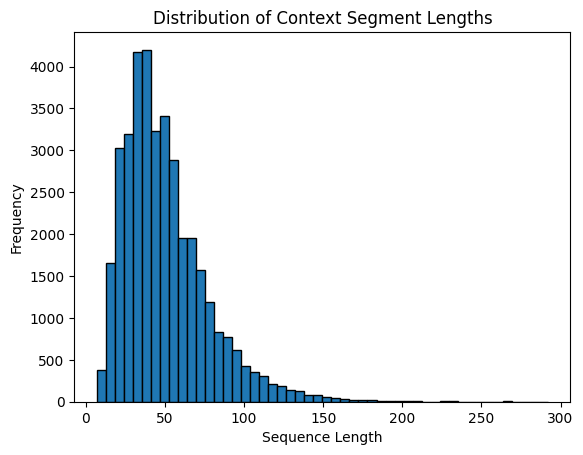

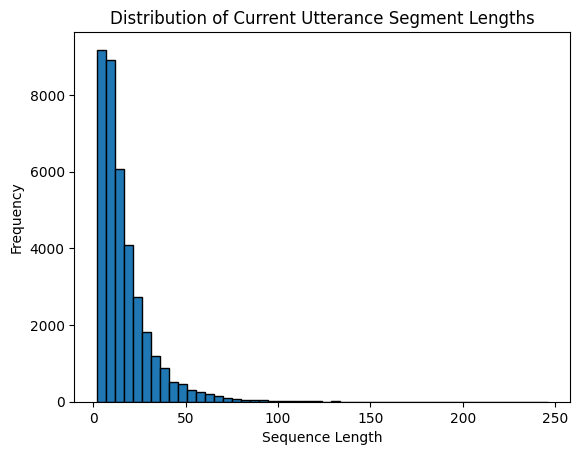

In [ ]:
input_ids = train_encodings['input_ids'].numpy()
attention_mask = train_encodings['attention_mask'].numpy()
token_type_ids = train_encodings['token_type_ids'].numpy()

context_lengths = []
current_lengths = []

# Iterate over each sample
for i in range(input_ids.shape[0]):
    tt_ids = token_type_ids[i]
    att_mask = attention_mask[i]

    # Context segment
    context_mask = (tt_ids == 0) & (att_mask == 1)
    context_length = np.sum(context_mask)
    context_lengths.append(context_length)

    # Current utterance segment
    current_mask = (tt_ids == 1) & (att_mask == 1)
    current_length = np.sum(current_mask)
    current_lengths.append(current_length)

# Convert lists to numpy arrays
context_lengths = np.array(context_lengths)
current_lengths = np.array(current_lengths)

# Analyze context segment lengths
print("Context Segment Lengths:")
print(f"Max: {np.max(context_lengths)}")
print(f"Mean: {np.mean(context_lengths)}")
print(f"Median: {np.median(context_lengths)}")
print("Percentiles:")
print("50th percentile (median):", np.percentile(context_lengths, 50))
print("75th percentile:", np.percentile(context_lengths, 75))
print("90th percentile:", np.percentile(context_lengths, 90))
print("95th percentile:", np.percentile(context_lengths, 95))
print("99th percentile:", np.percentile(context_lengths, 99))

# Analyze current utterance segment lengths
print("\nCurrent Utterance Segment Lengths:")
print(f"Max: {np.max(current_lengths)}")
print(f"Mean: {np.mean(current_lengths)}")
print(f"Median: {np.median(current_lengths)}")
print("Percentiles:")
print("50th percentile (median):", np.percentile(current_lengths, 50))
print("75th percentile:", np.percentile(current_lengths, 75))
print("90th percentile:", np.percentile(current_lengths, 90))
print("95th percentile:", np.percentile(current_lengths, 95))
print("99th percentile:", np.percentile(current_lengths, 99))

# Plot histograms
plt.hist(context_lengths, bins=50, edgecolor='black')
plt.title('Distribution of Context Segment Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

plt.hist(current_lengths, bins=50, edgecolor='black')
plt.title('Distribution of Current Utterance Segment Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()


### 4.3.0 Model Definition

In [ ]:
def build_bert_multiclass_model(num_classes, max_length):
    """Builds a multi-class text classification model using BERT with context windows.

    Args:
        num_classes: The number of output classes (speakers).
        max_length: The maximum sequence length.

    Returns:
        A compiled Keras model.
    """

    # Load pre-trained BERT model
    bert_model = TFBertModel.from_pretrained('bert-base-cased')

    # Enable fine-tuning of BERT weights
    bert_model.trainable = True

    # Input Layers
    input_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="input_ids")
    token_type_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="token_type_ids")
    attention_mask = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="attention_mask")

    # BERT Layer
    bert_outputs = bert_model(
        input_ids=input_ids,
        token_type_ids=token_type_ids,
        attention_mask=attention_mask
    )

    # Classification Head
    pooler_output = bert_outputs.pooler_output  # Shape: (batch_size, hidden_size)

    # Dense Layer
    hidden = tf.keras.layers.Dense(201, activation="relu")(pooler_output)

    # Dropout Layer
    dropout = tf.keras.layers.Dropout(0.3)(hidden)

    # Classification Layer
    classification_output = tf.keras.layers.Dense(
        num_classes, activation="softmax")(dropout)

    # Create the Keras model
    model = tf.keras.Model(
        inputs=[input_ids, token_type_ids, attention_mask],
        outputs=classification_output
    )

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model


### 4.3.1 Callbacks and Random Seeds

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=1,
    min_lr=1e-6
)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


### 4.3.2 Model Training

In [ ]:
# Determine the number of speakers
num_speakers = len(np.unique(y_train_encoded))

# Build the model
model = build_bert_multiclass_model(num_speakers, max_length)

# Train the model
history = model.fit(
    x={
        'input_ids': train_encodings['input_ids'],
        'token_type_ids': train_encodings['token_type_ids'],
        'attention_mask': train_encodings['attention_mask']
    },
    y=y_train_encoded,
    validation_data=(
        {
            'input_ids': val_encodings['input_ids'],
            'token_type_ids': val_encodings['token_type_ids'],
            'attention_mask': val_encodings['attention_mask']
        },
        y_val_encoded
    ),
    epochs=5,
    batch_size=16,
    callbacks=[early_stopping, reduce_lr]
)


Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/5
2326/2326 [==============================] - 1048s 433ms/step - loss: 1.8769 - accuracy: 0.2318 - val_loss: 1.7772 - val_accuracy: 0.3137 - lr: 2.0000e-05
Epoch 2/5
2326/2326 [==============================] - 999s 430ms/step - loss: 1.6801 - accuracy: 0.3543 - val_loss: 1.7565 - val_accuracy: 0.3324 - lr: 2.0000e-05
Epoch 3/5
2326/2326 [==============================] - 997s 428ms/step - loss: 1.4503 - accuracy: 0.4572 - val_loss: 1.7856 - val_accuracy: 0.3427 - lr: 2.0000e-05
Epoch 4/5
2326/2326 [==============================] - 998s 429ms/step - loss: 1.0689 - accuracy: 0.6100 - val_loss: 2.0128 - val_accuracy: 0.3423 - lr: 1.0000e-05


### 4.3.3 Model Evaluation

In [ ]:
# Evaluate the model
_, test_accuracy = model.evaluate(
    x={
        'input_ids': test_encodings['input_ids'],
        'token_type_ids': test_encodings['token_type_ids'],
        'attention_mask': test_encodings['attention_mask']
    },
    y=y_test_encoded
)
print(f"Test Accuracy: {test_accuracy}")

# Additional evaluation (per-class metrics)
from sklearn.metrics import classification_report

y_pred_probs = model.predict(
    x={
        'input_ids': test_encodings['input_ids'],
        'token_type_ids': test_encodings['token_type_ids'],
        'attention_mask': test_encodings['attention_mask']
    }
)
y_pred = np.argmax(y_pred_probs, axis=1)
print(classification_report(y_test_encoded, y_pred, target_names=le.classes_))


195/195 [==============================] - 50s 257ms/step - loss: 1.7715 - accuracy: 0.3207
Test Accuracy: 0.3207395374774933
195/195 [==============================] - 52s 253ms/step
                precision    recall  f1-score   support

 Chandler Bing       0.22      0.38      0.28       677
Joey Tribbiani       0.41      0.39      0.40       909
 Monica Geller       0.26      0.29      0.28       812
         Other       0.32      0.48      0.39       979
 Phoebe Buffay       0.29      0.22      0.25       773
  Rachel Green       0.37      0.30      0.33      1086
   Ross Geller       0.53      0.18      0.27       984

      accuracy                           0.32      6220
     macro avg       0.34      0.32      0.31      6220
  weighted avg       0.35      0.32      0.32      6220



### 4.3.4 Confusion Matrix

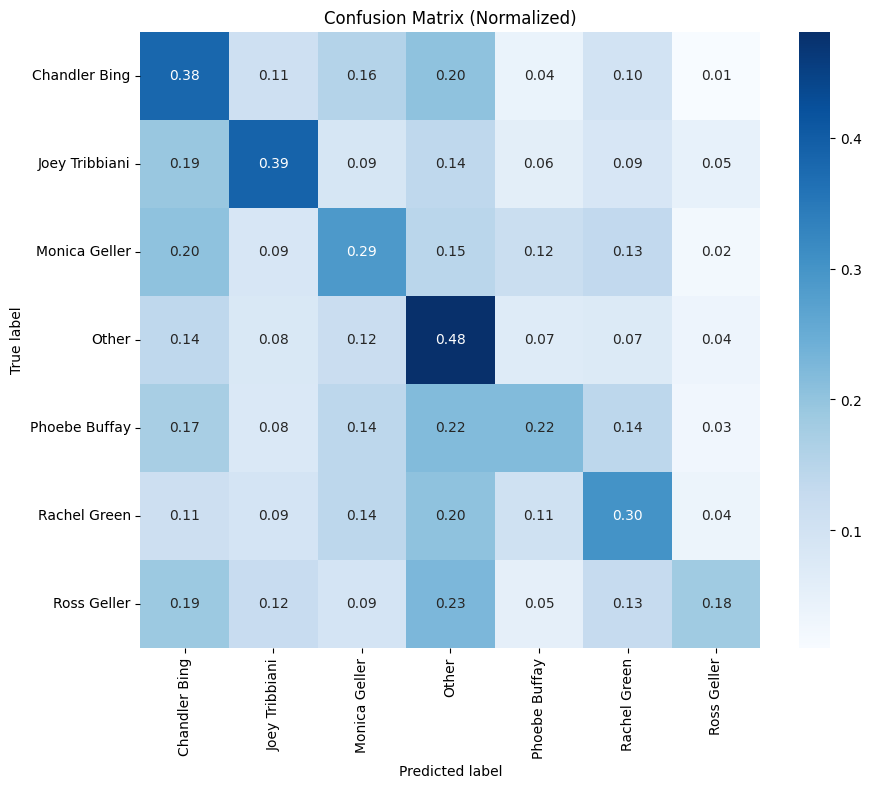

In [ ]:
def create_and_plot_confusion_matrix(y_true, y_pred, target_names):
    """Creates and plots a confusion matrix.

    Args:
        y_true: True labels (NumPy array).
        y_pred: Predicted labels (NumPy array).
        target_names: List of class names (strings).
    """

    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # Normalize for percentages

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm_normalized,
        annot=True,
        fmt=".2f",  # Format numbers to two decimal places
        xticklabels=target_names,
        yticklabels=target_names,
        cmap="Blues",
    )
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title("Confusion Matrix (Normalized)")
    plt.show()


create_and_plot_confusion_matrix(y_test_encoded, y_pred, le.classes_)

### 4.3.5 Model Summary

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 500)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 500)]                0         []                            
 )                                                                                                
                                                                                                  
 token_type_ids (InputLayer  [(None, 500)]                0         []                            
 )                                                                                                
                                                                                            

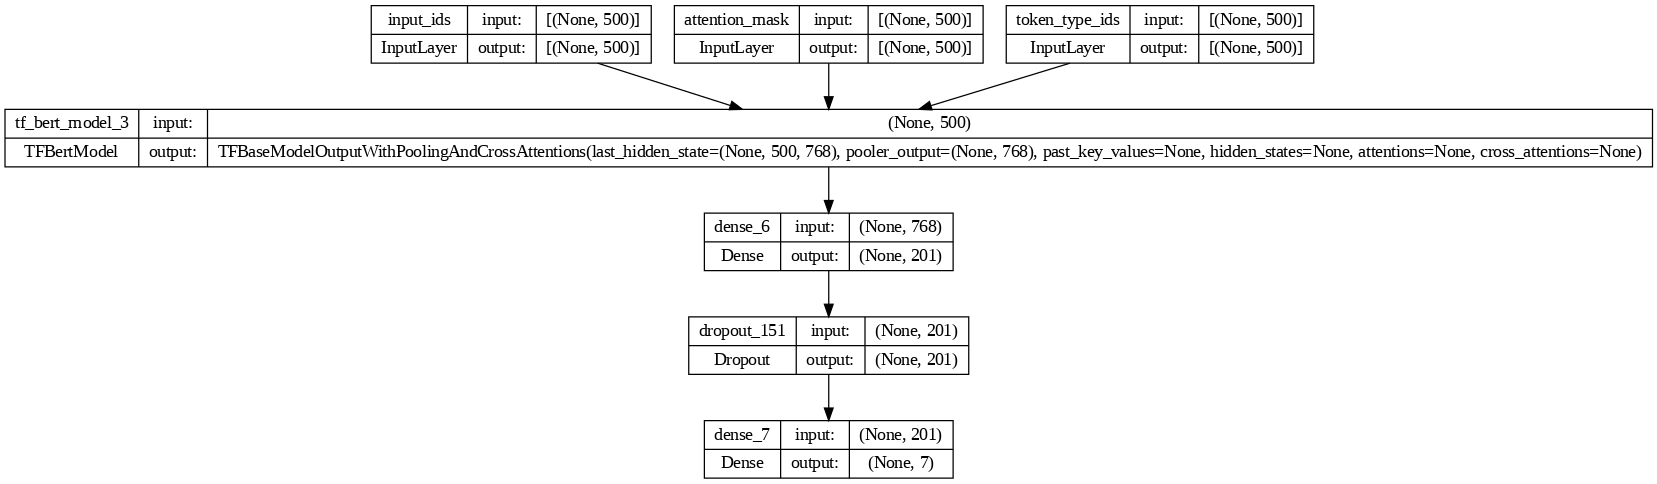

In [ ]:
model.summary()
keras.utils.plot_model(model, show_shapes=True, dpi=90)

### 4.3.6 Error Analysis

In [ ]:
y_true = y_test_encoded  # True labels

# Map encoded labels back to original labels
true_labels = le.inverse_transform(y_true)
predicted_labels = le.inverse_transform(y_pred)

# Get the test utterances and context
test_utterances = x_test  # Original test utterances
test_context_texts, test_current_utterances, _ = prepare_data_with_context(
    x_test, y_test, context_window_size
)

# Create a DataFrame with the results
error_df = pd.DataFrame({
    'Context': test_context_texts,
    'Current_Utterance': test_current_utterances,
    'True_Label': true_labels,
    'Predicted_Label': predicted_labels
})

# Identify misclassified examples
misclassified_df = error_df[error_df['True_Label'] != error_df['Predicted_Label']]

In [ ]:
# Set pandas option to display full text
pd.set_option('display.max_colwidth', None)

In [ ]:
misclassified_df

,Context,Current_Utterance,True_Label,Predicted_Label
0,[PAD] [SEP] [PAD] [SEP] [PAD],Great. Great! Just give me a sec to change film.,Other,Joey Tribbiani
1,[PAD] [SEP] [PAD] [SEP] Great. Great! Just give me a sec to change film.,Okay.,Monica Geller,Chandler Bing
2,[PAD] [SEP] Great. Great! Just give me a sec to change film. [SEP] Okay.,"Okay, I know I'm not supposed to know, but I do. And I'm so excited for you!",Ross Geller,Phoebe Buffay
4,"Okay. [SEP] Okay, I know I'm not supposed to know, but I do. And I'm so excited for you! [SEP] What? What's going on?",Monica's pregnant!,Ross Geller,Phoebe Buffay
5,"Okay, I know I'm not supposed to know, but I do. And I'm so excited for you! [SEP] What? What's going on? [SEP] Monica's pregnant!",Oh my God! Is that why you guys had to get married?!,Joey Tribbiani,Phoebe Buffay
...,...,...,...,...
6211,"I'm just saying that y'know, someday Ross is gonna meet somebody and...he's gonna have his own life. Right? [SEP] Yeah, I guess so. [SEP] I just never thought I would raise this baby all by myself. Pretty dumb huh?","Hey, listen to me, listen to me...you are never ever gonna be alone. Okay? I promise that's not gonna happen.",Joey Tribbiani,Chandler Bing
6214,"Hey, listen to me, listen to me...you are never ever gonna be alone. Okay? I promise that's not gonna happen. [SEP] Joey. Honey what would I do without you? [SEP] You don't have to worry about that okay?","Oh, hon can you grab me my other box of tissues? They're right on that chair under Ross's coat.",Rachel Green,Joey Tribbiani
6217,"Oh, hon can you grab me my other box of tissues? They're right on that chair under Ross's coat. [SEP] Sure. [SEP] Okay.",My God.,Joey Tribbiani,Rachel Green
6218,Sure. [SEP] Okay. [SEP] My God.,Joey.,Rachel Green,Monica Geller


## 4.2 BERT Baseline
A fine-tuned BERT model without additional context or syntactic features

#### 4.2.1 BERT encodings

#### Determine max length of transcripts

In [ ]:
# Find the maximum length of sequences in x_train
max_length = max(len(text.split()) for text in x_train)
max_length

173

#### BERT Tokenizer

In [ ]:
# 1. BERT Tokenization
model_checkpoint = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
max_length = 200

train_encodings = tokenizer(
    list(x_train),
    truncation=True,
    padding='max_length',  # Pad to max_length
    max_length=max_length,
    return_tensors='tf'
)

val_encodings = tokenizer(
    list(x_val),
    truncation=True,
    padding='max_length',
    max_length=max_length,
    return_tensors='tf'
)

test_encodings = tokenizer(
    list(x_test),
    truncation=True,
    padding='max_length',
    max_length=max_length,
    return_tensors='tf'
)

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

#### Model definition

In [ ]:
def build_bert_multiclass_model(num_classes, max_length):
    """Builds a multi-class text classification model using BERT.

    Args:
        num_classes: The number of output classes (speakers).
        max_length: The maximum sequence length.

    Returns:
        A compiled Keras model.
    """

    # 0. BERT Configurations ###################################################
    # Load pre-trained BERT model
    bert_model = TFBertModel.from_pretrained(model_checkpoint)

    # Enable fine-tuning of BERT weights
    bert_model.trainable = True

    # 1. Input Layers ##########################################################
    # Define input layers for BERT.
    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="token_type_ids")
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="attention_mask")

    # 2. BERT Layer
    # Pass inputs to the pre-trained BERT model.
    bert_outputs = bert_model(
        input_ids=input_ids,
        token_type_ids=token_type_ids,
        attention_mask=attention_mask
    )

    # 3. Classification Head
    # Extract the pooler_output which is a single vector representation of the entire sentence
    pooler_output = bert_outputs.pooler_output

    # 3.1 Dense Layer ##########################################################
    # Add a fully connected dense layer with ReLU activation
    hidden = tf.keras.layers.Dense(201, activation="relu")(pooler_output)

    # 3.2 Dropout Layer ########################################################
    # Add a dropout layer for regularization.
    dropout = tf.keras.layers.Dropout(0.3)(hidden)

    # 3.3 Classification Layer #################################################
    # Final classification layer with softmax for multiclass probability distribution
    classification_output = tf.keras.layers.Dense(num_classes, activation="softmax")(dropout)

    # Create the Keras model using the functional API
    model = tf.keras.Model(
        inputs=[input_ids, token_type_ids, attention_mask],
        outputs=classification_output)

    # Compile the model
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=1,
    min_lr=1e-6
)

#### Model Training and Evaluation

In [ ]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# 4. Model Training and Evaluation
num_speakers = len(np.unique(y_train_encoded))
model = build_bert_multiclass_model(num_speakers, max_length)

history = model.fit([train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask],
          y_train_encoded,
          validation_data=([val_encodings.input_ids, val_encodings.token_type_ids, val_encodings.attention_mask],
                           y_val_encoded),
          epochs=5,
          batch_size=16,
          callbacks=[early_stopping, reduce_lr]
          # class_weight=class_weights_dict
          )

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/5
2326/2326 [==============================] - 1663s 697ms/step - loss: 1.9139 - accuracy: 0.2079 - val_loss: 1.8724 - val_accuracy: 0.2401 - lr: 2.0000e-05
Epoch 2/5
2326/2326 [==============================] - 1621s 697ms/step - loss: 1.8066 - accuracy: 0.2830 - val_loss: 1.8470 - val_accuracy: 0.2710 - lr: 2.0000e-05
Epoch 3/5
2326/2326 [==============================] - 1621s 697ms/step - loss: 1.6455 - accuracy: 0.3715 - val_loss: 1.8936 - val_accuracy: 0.2700 - lr: 2.0000e-05
Epoch 4/5
2326/2326 [==============================] - 1567s 674ms/step - loss: 1.3231 - accuracy: 0.5090 - val_loss: 2.0502 - val_accuracy: 0.2762 - lr: 1.0000e-05


#### Model Summary

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 200)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 200)]                0         []                            
 )                                                                                                
                                                                                                  
 token_type_ids (InputLayer  [(None, 200)]                0         []                            
 )                                                                                                
                                                                                              

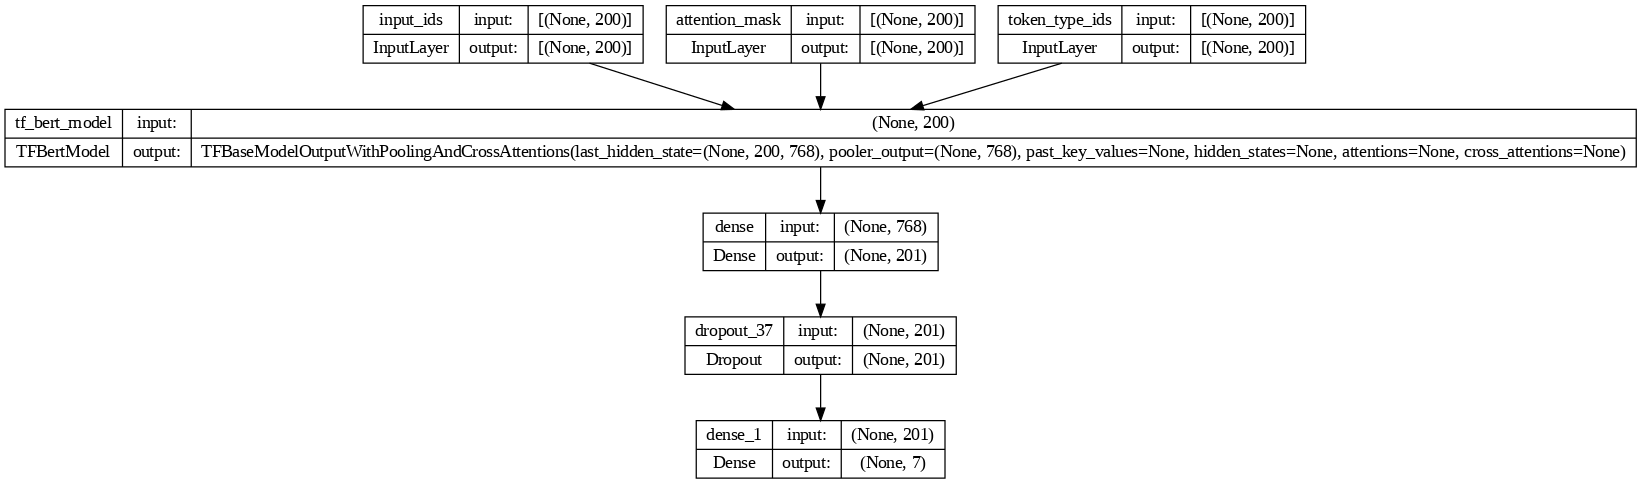

In [ ]:
keras.utils.plot_model(model, show_shapes=True, dpi=90)

#### Model Evaluation

In [ ]:
# Evaluate the model
_, test_accuracy = model.evaluate([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask], y_test_encoded)
print(f"Test Accuracy: {test_accuracy}")


# Additional evaluation (per-class metrics)
y_pred = model.predict([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask])
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test_encoded, y_pred, target_names=le.classes_))

195/195 [==============================] - 82s 420ms/step - loss: 1.8402 - accuracy: 0.2698
Test Accuracy: 0.2697749137878418
195/195 [==============================] - 83s 411ms/step
                precision    recall  f1-score   support

 Chandler Bing       0.18      0.34      0.23       677
Joey Tribbiani       0.31      0.33      0.32       909
 Monica Geller       0.20      0.18      0.19       812
         Other       0.33      0.37      0.35       979
 Phoebe Buffay       0.22      0.22      0.22       773
  Rachel Green       0.32      0.31      0.32      1086
   Ross Geller       0.42      0.14      0.21       984

      accuracy                           0.27      6220
     macro avg       0.28      0.27      0.26      6220
  weighted avg       0.29      0.27      0.27      6220



#### Confusion Matrix

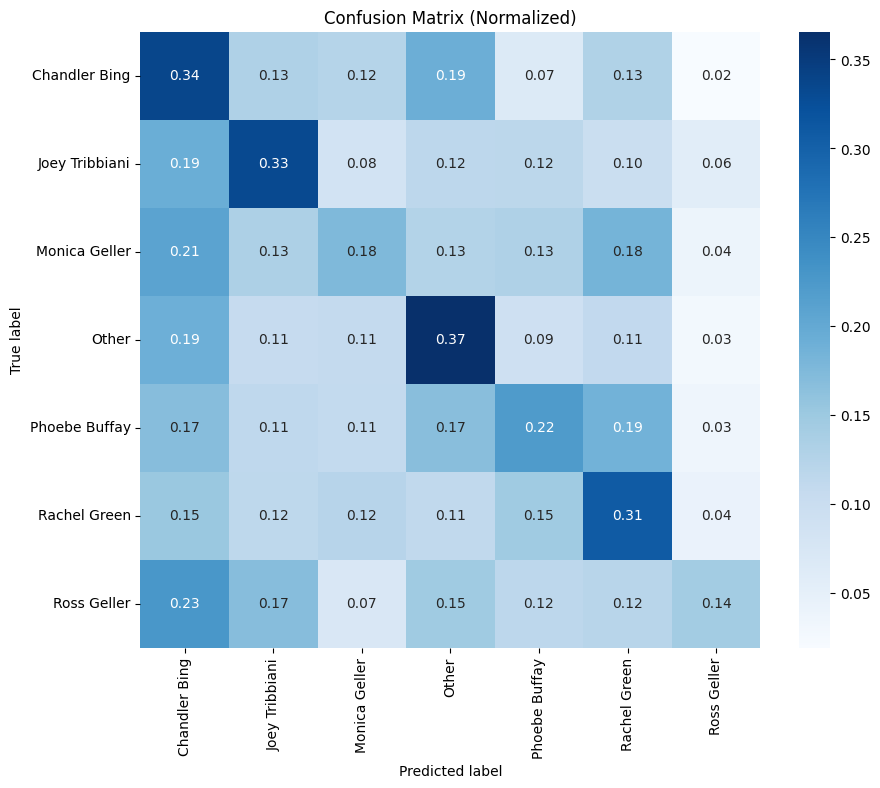

In [ ]:
def create_and_plot_confusion_matrix(y_true, y_pred, target_names):
    """Creates and plots a confusion matrix.

    Args:
        y_true: True labels (NumPy array).
        y_pred: Predicted labels (NumPy array).
        target_names: List of class names (strings).
    """

    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # Normalize for percentages

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm_normalized,
        annot=True,
        fmt=".2f",  # Format numbers to two decimal places
        xticklabels=target_names,
        yticklabels=target_names,
        cmap="Blues",
    )
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title("Confusion Matrix (Normalized)")
    plt.show()


create_and_plot_confusion_matrix(y_test_encoded, y_pred, le.classes_)

## 4.1: Majority Baseline
This model always predicts the most frequent class, "Other."

In [ ]:
def majority_class_metrics(y_true, majority_class):
    """Calculates metrics for a majority class classifier.

    Args:
        y_true: True labels.
        majority_class: The label of the majority class.

    Returns:
        precision, recall, f1, accuracy: Metrics for the majority class.
    """
    y_pred = np.full(len(y_true), majority_class)
    precision = round(precision_score(y_true, y_pred, average='macro', zero_division=0), 4)
    recall = round(recall_score(y_true, y_pred, average='macro', zero_division=0), 4)
    f1 = round(f1_score(y_true, y_pred, average='macro', zero_division=0), 4)
    accuracy = round(accuracy_score(y_true, y_pred), 4)
    return precision, recall, f1, accuracy


In [ ]:
majority_class = "Other"

train_precision, train_recall, train_f1, train_accuracy = majority_class_metrics(y_train, majority_class)
val_precision, val_recall, val_f1, val_accuracy = majority_class_metrics(y_val, majority_class)
test_precision, test_recall, test_f1, test_accuracy = majority_class_metrics(y_test, majority_class)

print("Train - Precision:", train_precision, "Recall:", train_recall, "F1:", train_f1, "Accuracy:", train_accuracy)
print("Val - Precision:", val_precision, "Recall:", val_recall, "F1:", val_f1, "Accuracy:", val_accuracy)
print("Test - Precision:", test_precision, "Recall:", test_recall, "F1:", test_f1, "Accuracy:", test_accuracy)

Train - Precision: 0.0242 Recall: 0.1429 F1: 0.0413 Accuracy: 0.1692
Val - Precision: 0.0202 Recall: 0.1429 F1: 0.0354 Accuracy: 0.1416
Test - Precision: 0.0225 Recall: 0.1429 F1: 0.0389 Accuracy: 0.1574


# 2: EDA

In [ ]:
df.shape

(67373, 7)

In [ ]:
df.columns

Index(['season_id', 'episode_id', 'scene_id', 'utterance_id', 'speaker',
       'tokens', 'transcript'],
      dtype='object')

In [ ]:
df[['speaker', 'utterance_id', 'transcript']]

,speaker,utterance_id,transcript
0,Monica Geller,u001,There's nothing to tell! He's just some guy I ...
1,Joey Tribbiani,u002,"C'mon, you're going out with the guy! There's ..."
2,Chandler Bing,u003,"All right Joey, be nice. So does he have a hum..."
3,Phoebe Buffay,u004,"Wait, does he eat chalk?"
5,Phoebe Buffay,u006,"Just, 'cause, I don't want her to go through w..."
...,...,...,...
67368,Chandler Bing,u017,"Oh, it's gonna be okay."
67369,Rachel Green,u018,Do you guys have to go to the new house right ...
67370,Monica Geller,u019,We got some time.
67371,Rachel Green,u020,"Okay, should we get some coffee?"


In [ ]:
df.dtypes

,0
season_id,object
episode_id,object
scene_id,object
utterance_id,object
speaker,object
tokens,object
transcript,object


In [ ]:
df.describe().T

,count,unique,top,freq
season_id,67373,10,s03,7267
episode_id,67373,25,e16,3015
scene_id,67373,29,c02,7133
utterance_id,67373,257,u001,3106
speaker,67373,700,Rachel Green,9331
tokens,67373,51359,[],6064
transcript,61310,51368,Hey!,661


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67373 entries, 0 to 67372
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   season_id     67373 non-null  object
 1   episode_id    67373 non-null  object
 2   scene_id      67373 non-null  object
 3   utterance_id  67373 non-null  object
 4   speaker       67373 non-null  object
 5   tokens        67373 non-null  object
 6   transcript    61310 non-null  object
dtypes: object(7)
memory usage: 3.6+ MB


In [ ]:
# Check distribution for each column.
for col in df.columns:
  print(f"Column name: {col}")
  print(df[col].value_counts(dropna=False))
  print("-"*50)
  print("\n")

Column name: season_id
season_id
s03    7267
s06    7235
s04    7119
s05    7082
s07    7019
s08    6845
s09    6653
s01    6626
s02    6048
s10    5479
Name: count, dtype: int64
--------------------------------------------------


Column name: episode_id
episode_id
e16    3015
e13    2972
e17    2963
e05    2920
e24    2919
e01    2911
e11    2842
e06    2830
e14    2809
e15    2809
e08    2784
e21    2780
e10    2766
e12    2753
e09    2748
e03    2743
e18    2741
e22    2666
e23    2652
e07    2652
e19    2643
e02    2629
e04    2621
e20    2601
e25     604
Name: count, dtype: int64
--------------------------------------------------


Column name: scene_id
scene_id
c02    7133
c03    6447
c04    5494
c01    5382
c05    5086
c07    4924
c08    4906
c06    4786
c10    4251
c11    4243
c09    4009
c12    3771
c13    2510
c14    1725
c15    1152
c16     568
c18     215
c17     212
c19     190
c20      88
c21      62
c24      59
c28      39
c26      38
c22      28
c23      28
c25      18

## 2.1 Visualizations

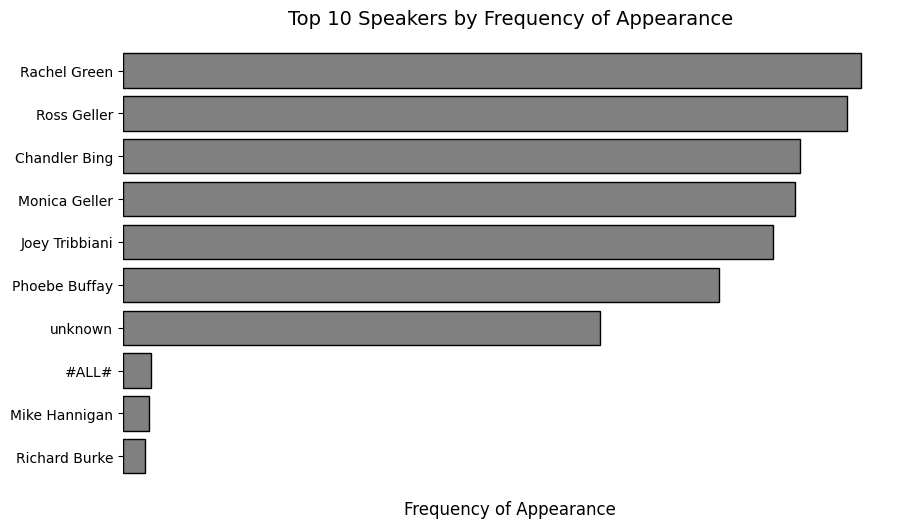

In [ ]:
# Calculate the frequency of each speaker and select the top 10
top_speakers = df['speaker'].value_counts().head(10)

# Plot frequency chart.
plt.figure(figsize=(10, 6))
plt.barh(top_speakers.index, top_speakers.values, color='grey', edgecolor='black')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest value on top

# Remove grid and spines for low ink-to-information ratio
plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

# Label axes
plt.xlabel('Frequency of Appearance', fontsize=12)
plt.xticks([])
plt.title('Top 10 Speakers by Frequency of Appearance', fontsize=14)

plt.show()

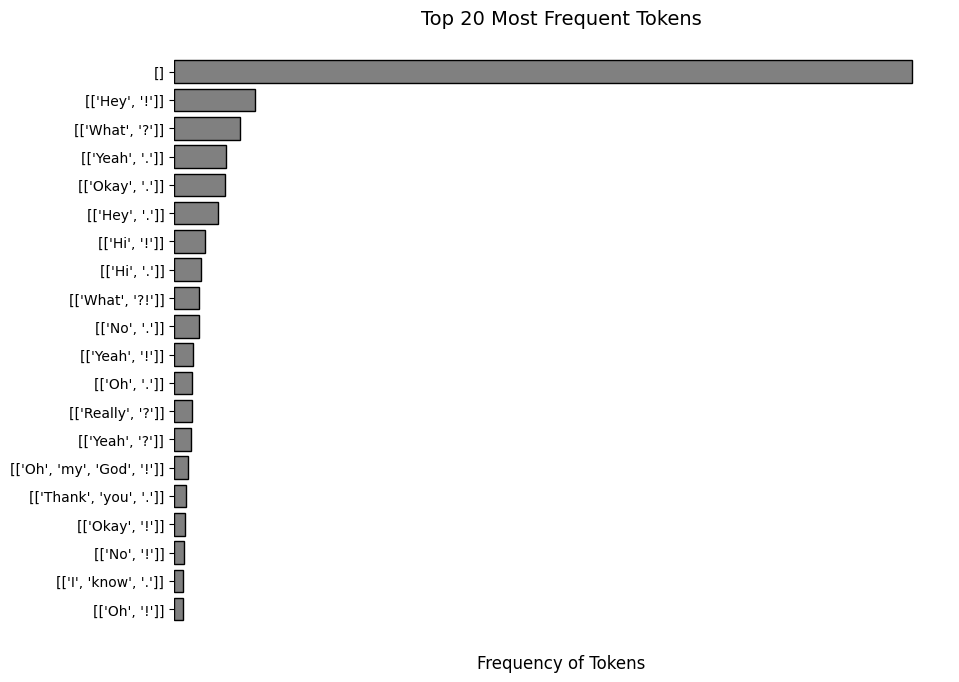

In [ ]:
# Calculate the frequency of each unique entry in the "tokens" column and select the top 20
top_tokens = df['tokens'].value_counts().head(20)

# Plotting the horizontal bar chart
plt.figure(figsize=(10, 8))
plt.barh(top_tokens.index.astype(str), top_tokens.values, color='grey', edgecolor='black')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest value on top

plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

# Label axes
plt.xlabel('Frequency of Tokens', fontsize=12)
plt.xticks([])
plt.title('Top 20 Most Frequent Tokens', fontsize=14)

plt.show()

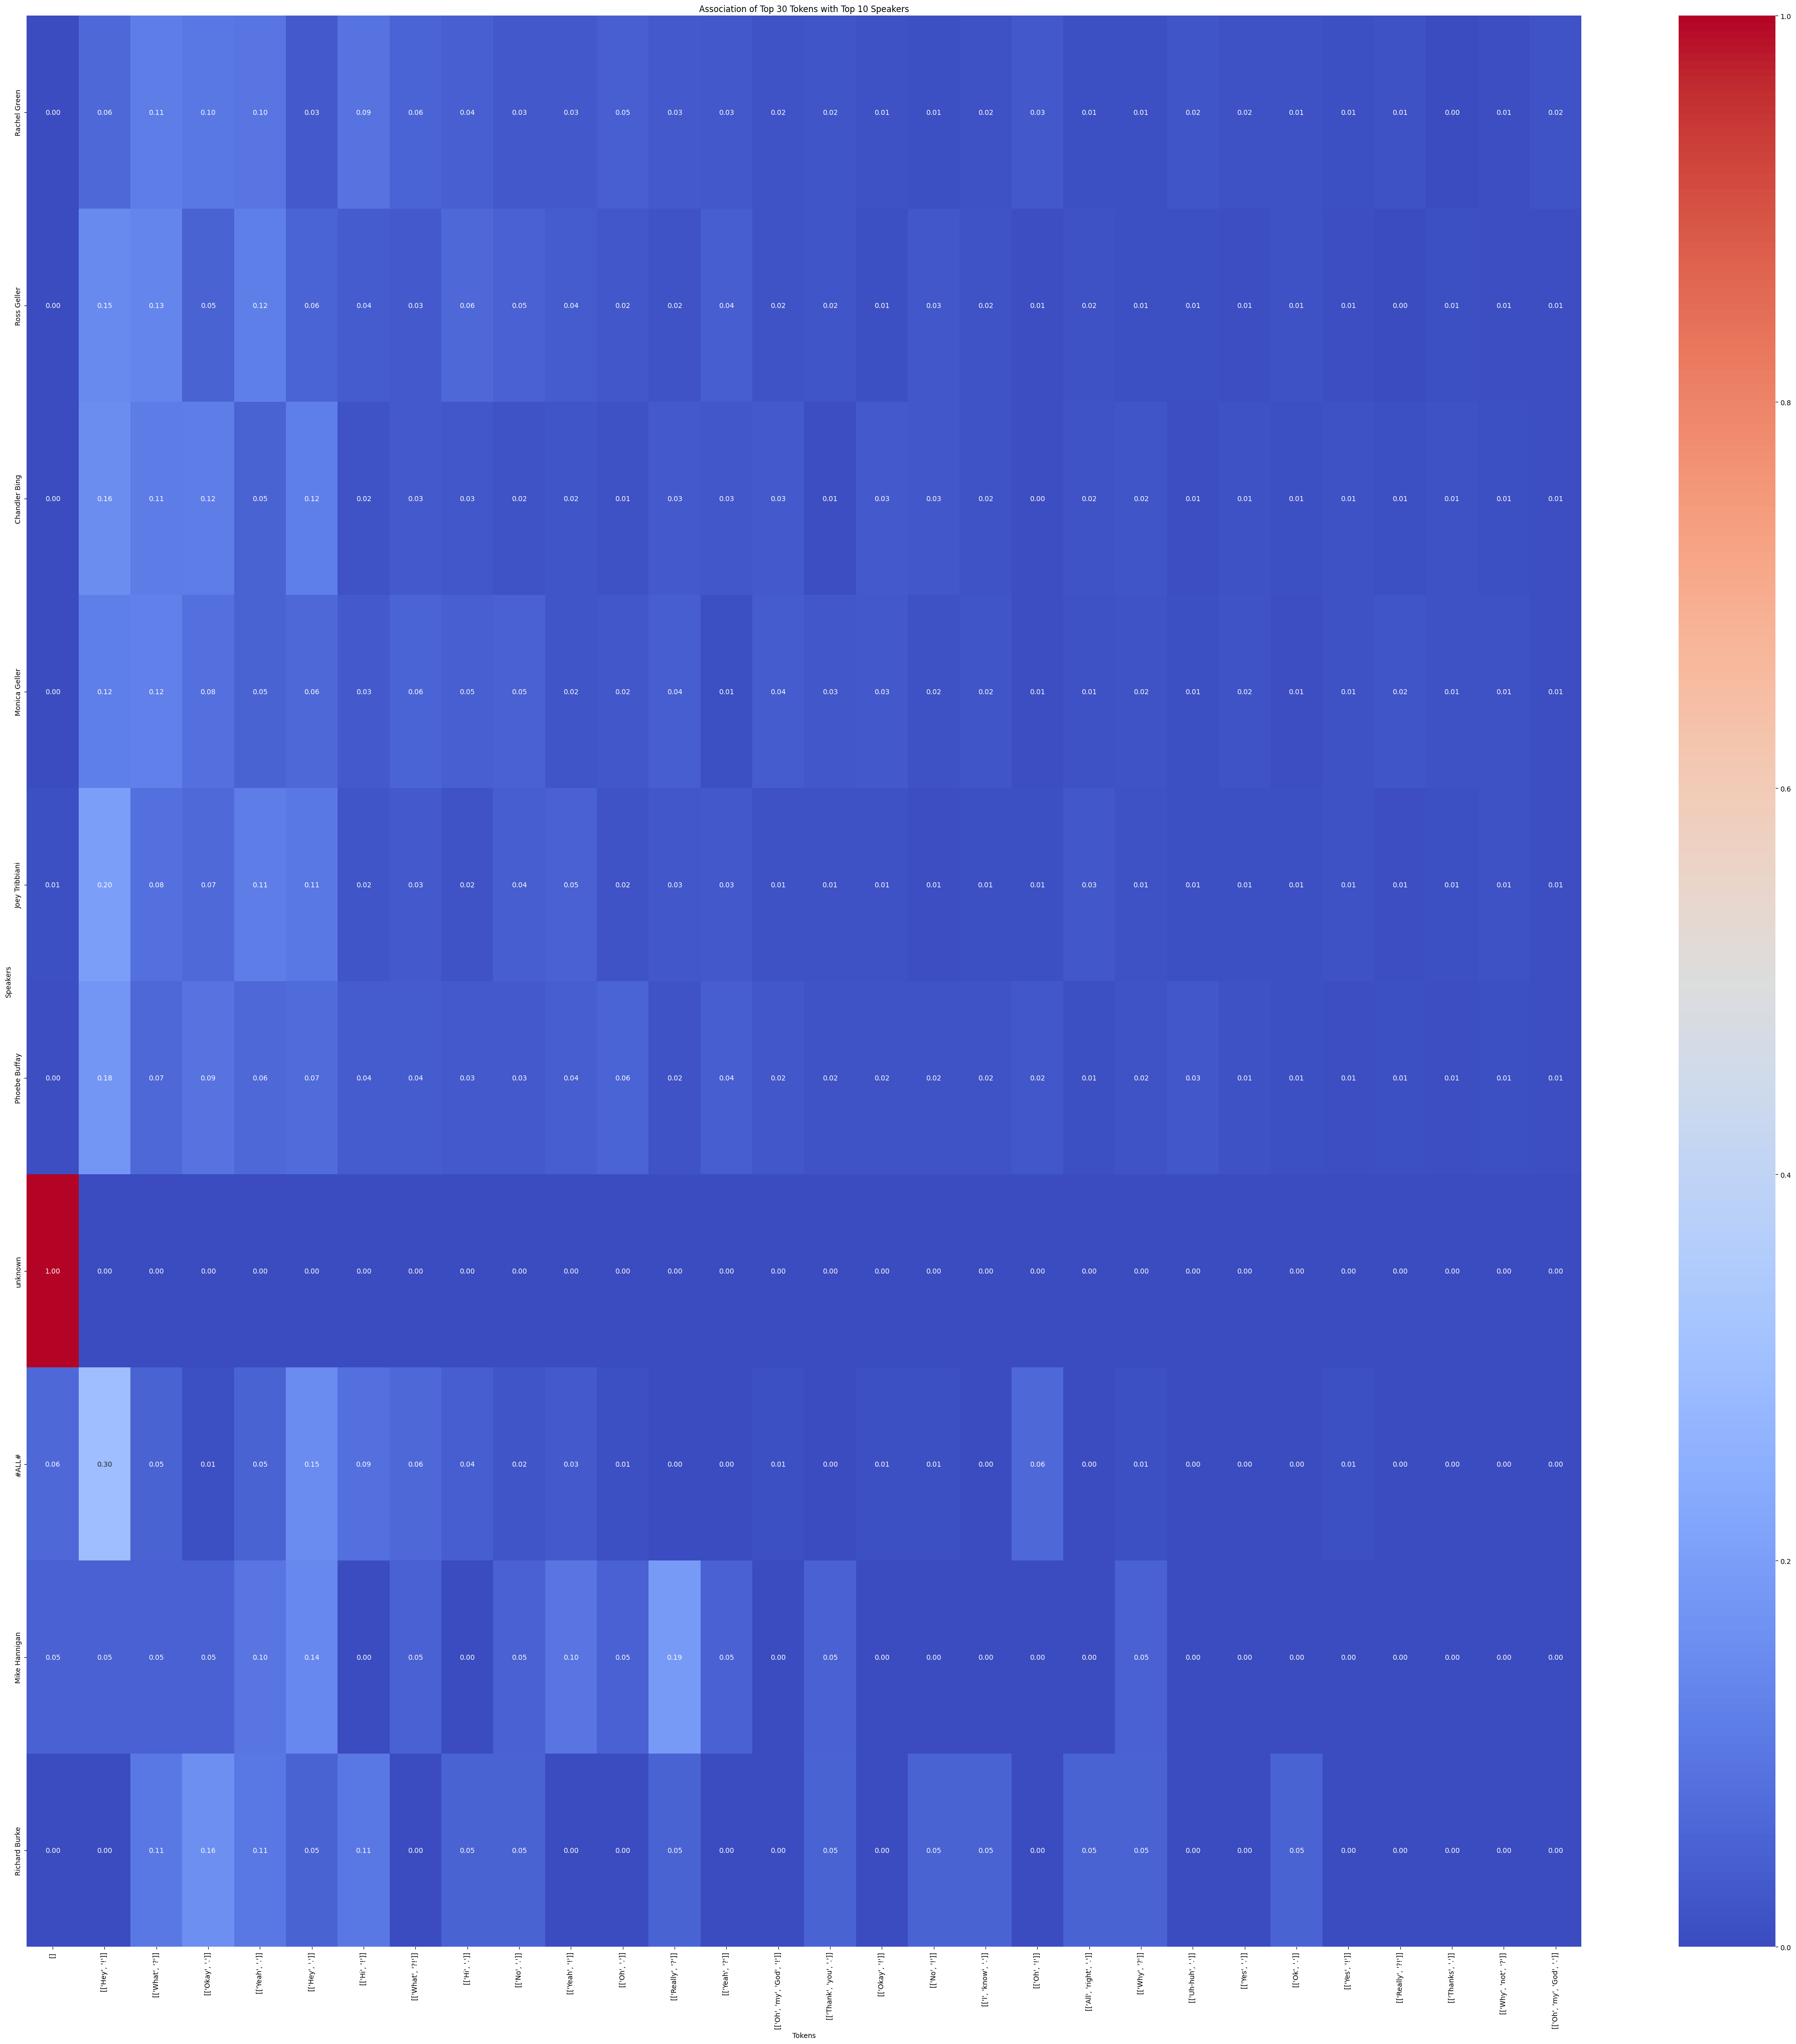

In [ ]:
# Step 1: Get top 10 speakers by frequency
top_speakers = df['speaker'].value_counts().head(10).index

# Step 2: Filter the DataFrame to include only these top speakers
df_top_speakers = df[df['speaker'].isin(top_speakers)]

# Step 3: Get top 30 tokens by frequency in the filtered dataset
df_tokens = df_top_speakers.explode('tokens')
top_tokens = df_tokens['tokens'].value_counts().head(30).index

# Step 4: Calculate frequency of each token for each speaker
token_speaker_matrix = pd.DataFrame(0, index=top_speakers, columns=top_tokens)
for speaker in top_speakers:
    for token in top_tokens:
        token_speaker_matrix.loc[speaker, token] = df_tokens[(df_tokens['speaker'] == speaker) & (df_tokens['tokens'] == token)].shape[0]

# Step 5: Normalize by row to get proportions (token usage per speaker)
token_speaker_matrix = token_speaker_matrix.div(token_speaker_matrix.sum(axis=1), axis=0)


note:

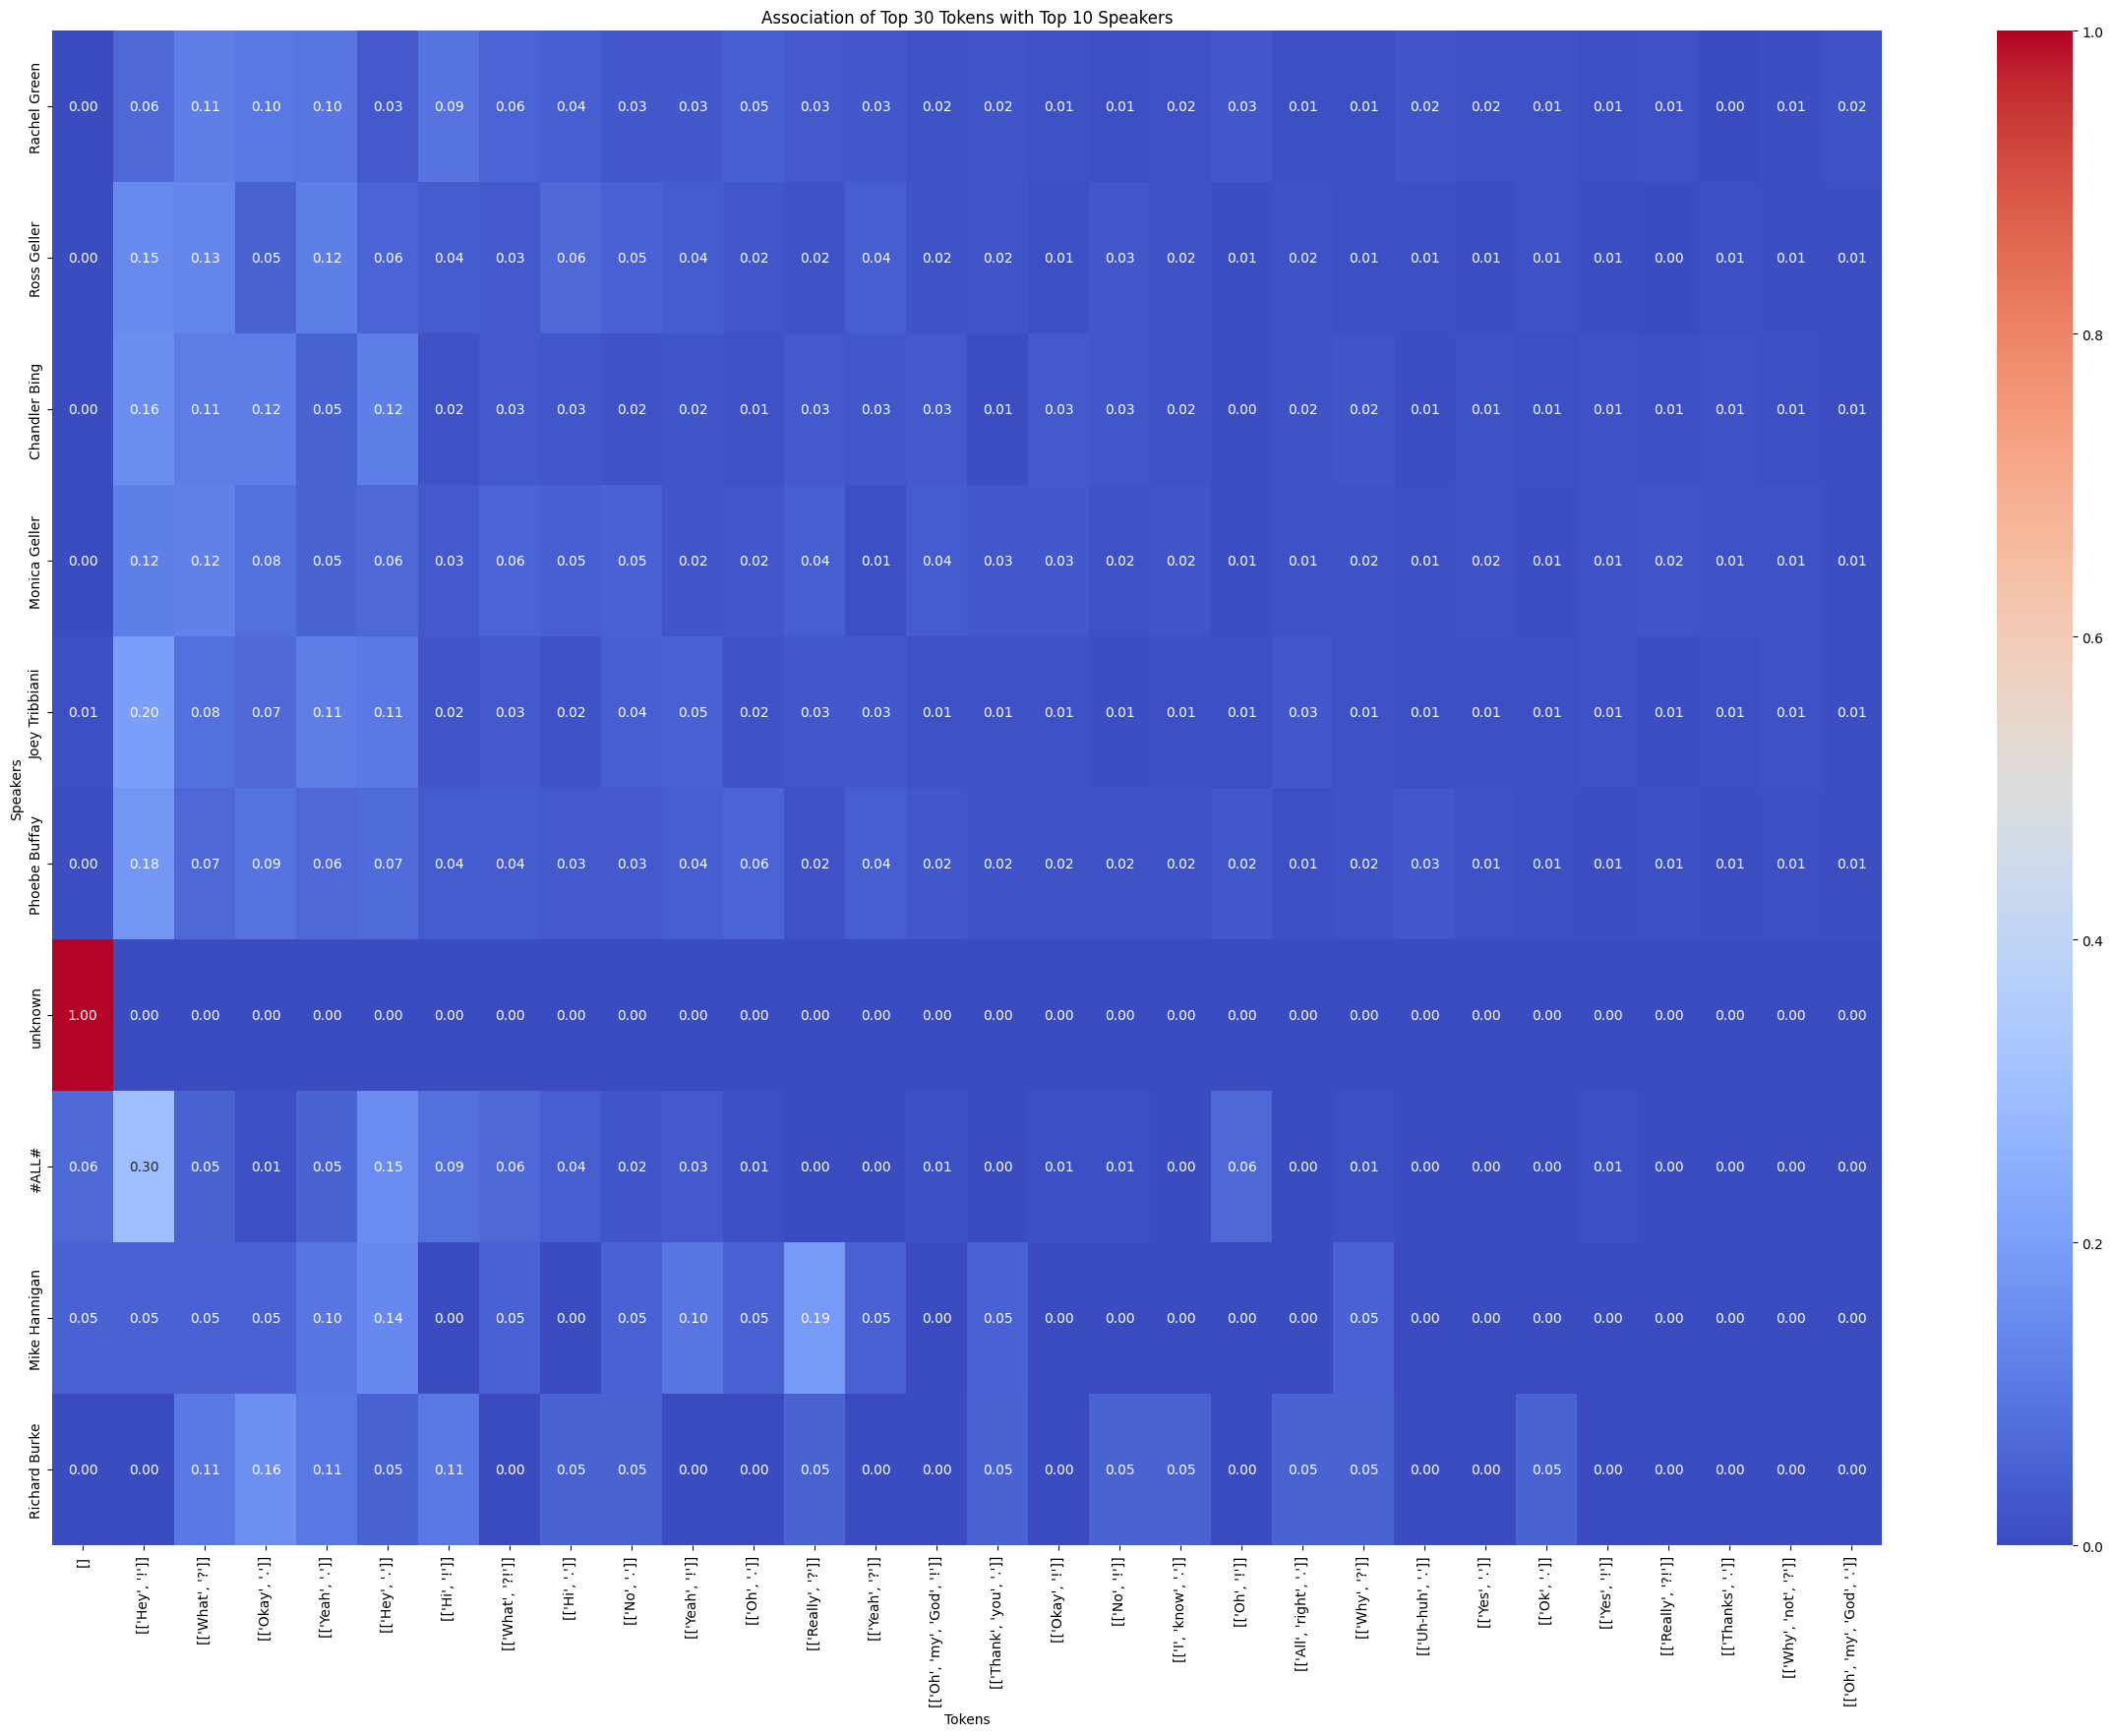

In [ ]:
# Step 6: Visualize as a heatmap
plt.figure(figsize=(30, 20))
sns.heatmap(token_speaker_matrix, cmap="coolwarm", annot=True, fmt=".2f", cbar=True)
plt.title("Association of Top 30 Tokens with Top 10 Speakers")
plt.xlabel("Tokens")
plt.ylabel("Speakers")
plt.show()

note: no strong correlations as expected. Although it's interesting that:
- Mike Hannigan appears to have a stronger correlation with "Really?" more than other characters.
- Ross and Monical Geller have an almost equal correlation to the word "What?"

